In [1]:
import pandas as pd
import numpy as np

import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns

from src.data_manipulation import transform_data_datetime

# ERA5 datasets

Scope of the notebook: once downloaded datasets from Copernicus website, we implement functions to:
- Read `grib` files
- Produce Hourly, daily, monthly, and yearly dataframes for Total Precipitation and 2 meters Temperature

## Reading `grib` files

### Grib Files Parameters for London and Puglia region

Data are downloaded from the [Copernicus Website](https://cds.climate.copernicus.eu/requests?tab=all)
- We can can double check London Data using the [Weather and Climate website ](https://weatherandclimate.com/london/july-2013)

#### London GRIB grid Parameters

For London, UK, you'll want to define a geographical area that encompasses the Greater London region. Here are suitable values for the grid boundaries:
- North: 51.7°N
- South: 51.3°N
- West: -0.5°W
- East: 0.3°E
These coordinates create a rectangular grid that covers Greater London and a small buffer around it. London's city center is approximately at 51.5°N, 0.1°W, so this grid provides good coverage while keeping the data volume manageable.

If you want a smaller area focused just on central London, you could use tighter bounds:

North: 51.6°N
South: 51.4°N
West: -0.3°W
East: 0.1°E

Or if you need a larger area covering the broader London metropolitan region, you could expand to:

North: 52.0°N
South: 51.0°N
West: -1.0°W
East: 1.0°E

The first set of coordinates (51.7°N, 51.3°N, -0.5°W, 0.3°E) is probably your best bet for most applications - it captures London proper without being unnecessarily large.


```
North: 51.6
West:  -0.2
South: 51.4
East:   0.1
```

#### Puglia Region GRIB grid Parameters

For comparing London and Puglia climate data, here's a suitable approach:

- Grid Selection Strategy
Option 1: Two separate queries (Recommended)

Query London area: North 51.7°N, South 51.3°N, West -0.5°W, East 0.3°E
Query Puglia area: North 41.9°N, South 39.8°N, West 15.5°E, East 18.5°E

Option 2: Single large query covering both regions

North 51.7°N, South 39.8°N, West -0.5°W, East 18.5°E
This creates a massive grid covering most of Europe, resulting in much larger files

I'd recommend Option 1 as it's more efficient and gives you focused data for each region.
Puglia Grid Coordinates
Puglia (Apulia) occupies the "heel" of Italy's boot:

North: 41.9°N (around Foggia)
South: 39.8°N (around Santa Maria di Leuca)
West: 15.5°E (around Bari)
East: 18.5°E (Adriatic coast)

Data Extraction from GRIB Files
Once you have the .grib files, extract data using these approaches:
1. Point-based comparison:

Extract data for specific coordinates (e.g., London center: 51.5°N, -0.1°W; Bari: 41.1°N, 16.9°E)
Use tools like grib_get_data or Python libraries (xarray, pygrib)

2. Area-averaged comparison:

Calculate spatial averages for each region
This smooths out local variations and gives regional climate signals

3. Representative city comparison:

London: Extract nearest grid point to 51.5°N, -0.1°W
Puglia: Extract for major cities like Bari (41.1°N, 16.9°E) or Lecce (40.4°N, 18.2°E)

> grib_file = "./data/ERA5/ERA5_hourly_data_on_single_levels_from_1940_to_present.grib"  # Replace with your GRIB file path
- output_csv = "./output/ERA5_hourly_data_on_single_levels_from_1940_to_present.csv"  # Replace with desired output path
- hourly data from 2022 to 2024

> 

### GRIB to csv conversion

In [3]:
# Version 2: first working version
import warnings
warnings.filterwarnings("ignore")

import cfgrib
import xarray as xr
import pandas as pd
import numpy as np
from pathlib import Path

def grib_to_csv(grib_file_path,
                city_lat,
                city_lon,
                output_variable='tp', # output variable 'tp' for total precipitation, 't2m' for temperature at 2m
                city_name = 'london', # city name for output file 'london', 'puglia'
                print_debug=True,
                ):
    """
    Read GRIB file, extract data for London coordinates, and save as CSV.
    
    Parameters:
    grib_file_path (str): Path to the GRIB file
    output_csv_path (str): Path for output CSV file (optional)
    
    Returns:
    pandas.DataFrame: DataFrame with the extracted data
    """
    if print_debug:
        print(f"Reading GRIB file: {grib_file_path}")
    
    try:
        # Open GRIB file with xarray
        print('breakpoint 0') 
        datasets = cfgrib.open_datasets(grib_file_path)
        for i, ds in enumerate(datasets):
            print(f"Dataset {i}:")
            print(f"Variables: {list(ds.data_vars.keys())}")
            print(f"Time range: {ds.time.min().values} to {ds.time.max().values}")
            print("---")
        
        ds = xr.open_dataset(grib_file_path, engine='cfgrib')
        print('breakpoint 1')        
        # Check longitude format (0-360 vs -180-180)
        city_min = ds.longitude.min().values
        city_max = ds.longitude.max().values
        if print_debug:
            print(f"Longitude range: {city_min} to {city_max}")
        
        target_city = city_lon
        if print_debug:
            print(f"Using -180-180 longitude format: {target_city}")
        
        # Find nearest grid point to London
        lat_idx = np.abs(ds.latitude - city_lat).argmin()
        lon_idx = np.abs(ds.longitude - target_city).argmin()
        
        actual_lat = ds.latitude[lat_idx].values
        actual_lon = ds.longitude[lon_idx].values
        
        if print_debug:
            print(f"Target coordinates: ({city_lat}, {target_city})")
            print(f"Nearest grid point: ({actual_lat}, {actual_lon})")
        
        # Extract data for London coordinates
        city_data = ds.isel(latitude=lat_idx, longitude=lon_idx)
        
        # Convert to pandas DataFrame
        df_list = []
        
        for var_name in city_data.data_vars:
            var_data = city_data[var_name]
            
            # Handle different time dimensions
            if 'time' in var_data.dims:
                # Create DataFrame with time index
                df_var = var_data.to_dataframe().reset_index()
                df_var = df_var.rename(columns={var_name: var_name})
                df_list.append(df_var)
            elif 'valid_time' in var_data.dims:
                # Handle valid_time dimension
                df_var = var_data.to_dataframe().reset_index()
                df_var = df_var.rename(columns={var_name: var_name})
                df_list.append(df_var)
            else:
                # Single value variables
                df_var = pd.DataFrame({
                    var_name: [var_data.values],
                    'latitude': [actual_lat],
                    'longitude': [actual_lon]
                })
                df_list.append(df_var)
        
        # Combine all variables into one DataFrame
        if len(df_list) > 1:
            # Merge on common columns (time, latitude, longitude)
            df = df_list[0]
            for df_var in df_list[1:]:
                common_cols = set(df.columns) & set(df_var.columns)
                if common_cols:
                    df = pd.merge(df, df_var, on=list(common_cols), how='outer')
                else:
                    # If no common columns, concatenate side by side
                    df = pd.concat([df, df_var], axis=1)
        else:
            df = df_list[0]
        
        df['target_latitude'] = city_lat
        df['target_longitude'] = target_city
        
        # Sort by time if time column exists
        time_cols = [col for col in df.columns if 'time' in col.lower()]
        if time_cols:
            time_col = time_cols[0]
            df = df.sort_values(time_cols[0])
            if print_debug:
                print(f"****\n - inside csv Time range: {df[time_col].min()} to {df[time_col].max()}")
            min_string = df[time_col].min().strftime('%Y%m%d')
            max_string = df[time_col].max().strftime('%Y%m%d')
            if print_debug:
                print(f" - min time as string: {min_string}")
                print(f" - max time as string: {max_string}")
            output_csv_name = list(ds.data_vars)[0] + '_' + min_string + '_' + max_string
            if print_debug:
                print(output_csv_name)
        
        output_csv_name = city_name + '_' + output_csv_name
        if print_debug:
            print(f"DataFrame shape: {df.shape}")
            print(f"DataFrame columns: {list(df.columns)}")
            print("grib to csv")
            print(f"ds.data_vars dtype: {type(ds.data_vars)}, df.data_vars name: {list(ds.data_vars)[0]}")
            output_csv_path = './output/' + output_variable + '//' + city_name + '//' + output_csv_name + '.csv'
            print(output_csv_path)
        # print("\nFirst few rows:")
        # print(df.head())
        
        # Save to CSV
        if output_csv_path is None:
            output_csv_path = Path(grib_file_path).stem + "_city_data.csv"
        
        output_csv_path = './output/' + output_variable + '//' + city_name + '//' + output_csv_name + '.csv'
        print(output_csv_path)
        if print_debug:
            print(f"Saving DataFrame to: {output_csv_path}")
        

        df.to_csv(output_csv_path, index=False)
        print(f"\nData saved to: {output_csv_path}")
        
        return df
        
    except Exception as e:
        print(f"Error processing GRIB file: {e}")
        print("Make sure you have the required packages installed:")
        print("pip install xarray cfgrib pandas numpy")
        raise

In [ ]:
# def grib_to_csv(grib_file_path,
#                 city_lat,
#                 city_lon,
#                 output_variable='tp', # output variable 'tp' for total precipitation, 't2m' for temperature at 2m
#                 city_name = 'london', # city name for output file 'london', 'puglia'
#                 print_debug=False,
#                 ):

def process_grib_file(grib_file_path,
                      city_lat=51.5074,  # Default to London latitude
                      city_lon=-0.1278,  # Default to London longitude
                      output_variable='tp', # Default for total precipitation 
                      city_name='london', # Default city name for london
                      print_debug = False):  
    
    grib_file = grib_file_path  # Replace with your GRIB file path
    output_csv_city = city_name  # Replace with desired output path

    # Check if file exists
    if not Path(grib_file).exists():
        print(f"GRIB file not found: {grib_file}")
        print("Please update the 'grib_file' variable with the correct path to your GRIB file.")
        return
    
    try:
        df = grib_to_csv(grib_file,
                         city_lat=city_lat,
                         city_lon=-city_lon, 
                         output_variable = output_variable, 
                         city_name=city_name, 
                         print_debug=print_debug)
        
        # Display summary statistics
        if print_debug:
            print("\n" + "="*50)
            print("SUMMARY")
            print("="*50)
            print(f"Total records: {len(df)}")
        
        # Show time range if available
        time_cols = [col for col in df.columns if 'time' in col.lower()]
        if time_cols:
            time_col = time_cols[0]
            if print_debug:
                print(f"Time range: {df[time_col].min()} to {df[time_col].max()}")
        
        if print_debug:
            print(f"Variables extracted: {[col for col in df.columns if col not in ['latitude', 'longitude', 'actual_latitude', 'actual_longitude', 'target_latitude', 'target_longitude'] + time_cols]}")
        
        return df
        
    except Exception as e:
        print(f"Failed to process GRIB file: {e}")


In [ ]:
file_mame = 'data_london_2mt_1999_2004'
output_variable = file_mame.split('_')[2]
city_name = file_mame.split('_')[1]

In [ ]:
f_path = "./data/ERA5/" + output_variable + '/' + city_name + '/' + file_mame + '.grib'

In [ ]:
# Process the file
# Bari 41.14043890868558, 16.86619063277282
# Lecce 40.35654102220363, 18.17311913754415
# London 51.5074, -0.1278
file_mame = 'data_london_t2m_2025'
output_variable = file_mame.split('_')[2]
city_name = file_mame.split('_')[1]
file_path = "./data/ERA5/" + output_variable + '/' + city_name + '/' + file_mame + '.grib'

city_lat = 51.5074  # London latitude
city_lon = -0.1278  # London longitude
output_variable = output_variable
city_name = city_name
dubug = True

df_test = process_grib_file(grib_file_path = file_path,
                            city_lat=city_lat,
                            city_lon=city_lon,
                            output_variable=output_variable,
                            city_name=city_name,
                            print_debug=dubug
                            )

In [4]:
city_lat = 51.5074  # London latitude
city_lon = -0.1278  # London longitude

grib_to_csv('london_era5land_hourly_precip.grib',
            city_lat=city_lat,
            city_lon=city_lon)

Reading GRIB file: london_era5land_hourly_precip.grib
breakpoint 0


Can't create file 'london_era5land_hourly_precip.grib.5b7b6.idx'
Traceback (most recent call last):
  File "c:\ProgramData\anaconda3\Lib\site-packages\cfgrib\messages.py", line 274, in itervalues
    yield self.filestream.message_from_file(file, errors=errors)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\ProgramData\anaconda3\Lib\site-packages\cfgrib\messages.py", line 341, in message_from_file
    return Message.from_file(file, offset, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\ProgramData\anaconda3\Lib\site-packages\cfgrib\messages.py", line 105, in from_file
    raise EOFError("End of file: %r" % file)
EOFError: End of file: <_io.BufferedReader name='london_era5land_hourly_precip.grib'>

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\ProgramData\anaconda3\Lib\site-packages\cfgrib\messages.py", line 539, in from_indexpath_or_filestream
    self = cls.from_

Error processing GRIB file: No valid message found: 'london_era5land_hourly_precip.grib'
Make sure you have the required packages installed:
pip install xarray cfgrib pandas numpy


EOFError: No valid message found: 'london_era5land_hourly_precip.grib'

## Producing daily, monthly and yearly summary

As a result of opening and reading a `grib` file, we produce one `.csv` file containing the hourly report of Total Precipitation `tp` and another with hourly 2 meters temperature readings `t2m`. 

In this section, we will load the `.csv` file and produce daily, monthly and yearly aggregate summary for these measurements.

### Total Precipitation `tp`

The folder structure to retrieve the Total Precipitation file is:
- output
    - tp
        - london
        - puglia

> Strategy

1. Reading all csv files
2. Concatenating dataframes
3. Drop `NaN`s and duplicated
4. Producing daily, monthly and yearly aggregates 

In [ ]:
import glob
from pathlib import Path

from src.data_manipulation import transform_data_datetime

def create_hourly_dataset(files_base_folder = './output',
                        weather_var = 'tp',
                        city = 'london'):
    folder_path = Path(files_base_folder + '/' + weather_var + '/' + city)

    csv_files = list(folder_path.glob("*.csv"))

    # To get just the filenames:
    csv_filenames = [file.name for file in csv_files]
    print(csv_filenames)

    # To get full paths as strings:
    csv_paths = [str(file) for file in csv_files]
    print(csv_paths)

    dfs = []

    for file in csv_paths:
        df = pd.read_csv(file)
        df['valid_time'] = pd.to_datetime(df['valid_time'])
        df = (df[['valid_time', weather_var]]
            .sort_values('valid_time')
            .reset_index(drop=True)
            .dropna()
            ).copy()
        if (weather_var == 'tp'):
            df['tp_mm'] = df['tp'] * 1000
        print(df.shape)
        dfs.append(df)


    hourly_data = pd.concat(dfs, axis = 0)
    print(hourly_data.shape)
    # remove nans - redundant as they have already been removed in a previous step
    hourly_data.dropna(inplace=True)
    print(hourly_data.shape)
    # compute mean of duplicated records - same date and hour
    print(f"duplicated records: {hourly_data.duplicated().sum()}")
    hourly_data['date_hour'] = hourly_data['valid_time'].dt.floor('h')
    
    if weather_var == 'tp':
        df_24h = (hourly_data
                .groupby("date_hour")[['tp', 'tp_mm']]
                .mean()
                .reset_index()
                )
    else:
        df_24h = (hourly_data
                .groupby("date_hour")[weather_var]
                .mean()
                .reset_index()
                )
    
    df_24h.rename(columns = {'date_hour' : 'valid_time'}, inplace = True)
    print(f"duplicated records after mean: {df_24h.duplicated().sum()}")
    print(f"dataframe new shape: {df_24h.shape}")

    time_delta = (df_24h['valid_time'].max() - df_24h['valid_time'].min())
    n_expected_records = time_delta.components.days *24 +  time_delta.components.hours + 1
    print(f"number of expected records: {n_expected_records}")

    df_24h['hour_of_day'] = df_24h['valid_time'].dt.hour
    df_hourly = transform_data_datetime(df_24h, date_column='valid_time')
    
    
    filename = city + "_" + weather_var + '_' + "hourly_data"

    if weather_var == 'tp':
        features_list = ['valid_time', 'year', 'month', 'day', 'tp', 'tp_mm', 'hour_of_day', 'month int']
        df_hourly[features_list].to_pickle(str(folder_path) + '/' + filename + ".pkl")
    else:
        features_list = ['valid_time', 'year', 'month', 'day', weather_var, 'hour_of_day', 'month int']
        df_hourly[features_list].to_pickle(str(folder_path) + '/' + filename + ".pkl")
    return(df_hourly)
    

london_tp_hourly = create_hourly_dataset(files_base_folder='./output',
                                       weather_var='tp',
                                       city = 'london')

london_tp_hourly.head()

In [ ]:
london_tp_hourly.head()

In [ ]:
london_tp_hourly = pd.read_pickle('./output/tp/london/london_tp_hourly_data.pkl')
london_tp_hourly.head()

### Daily aggregate

#### 1. Create `date` column.

In [ ]:
london_tp_hourly['date'] = london_tp_hourly['valid_time'].dt.normalize()
london_tp_hourly.dtypes

#### 2. Groupby

In [ ]:
london_tp_daily = (london_tp_hourly
                   .groupby('date')
                   .agg(
                        year = ('year', 'first'),
                        month = ('month', 'first'),
                        day = ('day', 'first'),
                        tp_daily_sum = ('tp', 'sum'),
                        tp_daily_mean = ('tp', 'mean'),
                        tp_daily_std = ('tp', 'std'),
                        tp_daily_median = ('tp_mm', 'median'),
                        tp_daily_min = ('tp', 'min'),
                        tp_daily_max = ('tp', 'max'),
                        tp_daily_mm_mean = ('tp_mm', 'mean'),
                        tp_daily_mm_std = ('tp_mm', 'std'),
                        tp_daily_mm_median = ('tp_mm', 'median'),
                        tp_daily_mm_min = ('tp_mm', 'min'),
                        tp_daily_mm_max = ('tp_mm', 'max'),
 ).reset_index()
)

london_tp_daily

In [237]:
def create_daily_aggregate(file_folder = './output/tp/london/',
                           file_name = 'london_tp_hourly_data.pkl',
                           rainyday_threshold = 0):
    city = file_name.split('_')[0]
    weather_var = file_name.split('_')[1]
    print(f"city = {city}, var = {weather_var}")
    df = pd.read_pickle(file_folder + file_name)
    print(df.shape)
    print(f"columns = {df.columns}")
    if 'tp' in df.columns:
        df['date'] = df['valid_time'].dt.normalize()
        df_daily = (df
                   .groupby('date')
                   .agg(
                        year = ('year', 'first'),
                        month = ('month', 'first'),
                        day = ('day', 'first'),
                        
                        tp_daily_sum = ('tp', 'sum'),
                        tp_daily_mean = ('tp', 'mean'),
                        tp_daily_std = ('tp', 'std'),
                        tp_daily_median = ('tp', 'median'),
                        tp_daily_max = ('tp', 'max'),
                        tp_daily_min = ('tp', 'min'),

                        tp_mm_daily_sum = ('tp_mm', 'sum'),
                        tp_mm_daily_mean = ('tp_mm', 'mean'),
                        tp_mm_daily_std = ('tp_mm', 'std'),
                        tp_mm_daily_median = ('tp_mm', 'median'),
                        tp_mm_daily_min = ('tp_mm', 'min'),
                        tp_mm_daily_max = ('tp_mm', 'max')
                        ).reset_index()
                        )
        
        df_daily['month_int'] = df_daily['date'].dt.month

        df_daily['rainy_day'] = 0
        df_daily.loc[df_daily['tp_mm_daily_sum'] > rainyday_threshold, 'rainy_day'] = 1

        df_daily.sort_values('date', inplace = True)
        df_daily= df_daily.reset_index(drop = True)
        # saving result as .pkl file
        foutput = file_name.split('_')
        output_fname = file_folder + foutput[0] + '_' + foutput[1] + '_' + 'daily_data.pkl'
        print(output_fname)
        df_daily.to_pickle(output_fname)

        
        
        return(df_daily)
        
        

test = create_daily_aggregate()

city = london, var = tp
(231950, 8)
columns = Index(['valid_time', 'year', 'month', 'day', 'tp', 'tp_mm', 'hour_of_day',
       'month int'],
      dtype='object')
./output/tp/london/london_tp_daily_data.pkl


In [238]:
test.head(3)

,date,year,month,day,tp_daily_sum,tp_daily_mean,tp_daily_std,tp_daily_median,tp_daily_max,tp_daily_min,tp_mm_daily_sum,tp_mm_daily_mean,tp_mm_daily_std,tp_mm_daily_median,tp_mm_daily_min,tp_mm_daily_max,month_int,rainy_day
0,1999-01-01,1999,Jan,1,0.000115,0.000005,0.000010,0.000000,0.000034,0.0,0.114918,0.004788,0.010305,0.000000,0.0,0.034237,1,1
1,1999-01-02,1999,Jan,2,0.003636,0.000151,0.000345,0.000007,0.001358,0.0,3.635501,0.151479,0.344832,0.006628,0.0,1.358417,1,1
2,1999-01-03,1999,Jan,3,0.007048,0.000294,0.000489,0.000011,0.001751,0.0,7.048499,0.293687,0.489040,0.011015,0.0,1.751140,1,1


In [176]:
test.head()

,date,year,month,day,tp_daily_sum,tp_daily_mean,tp_daily_std,tp_daily_median,tp_daily_max,tp_daily_min,tp_mm_daily_sum,tp_mm_daily_mean,tp_mm_daily_std,tp_mm_daily_median,tp_mm_daily_min,tp_mm_daily_max,rainy_day
0,1999-01-01,1999,Jan,1,0.000115,4.788235e-06,0.000010,0.000000,0.000034,0.0,0.114918,0.004788,0.010305,0.000000,0.0,0.034237,1
1,1999-01-02,1999,Jan,2,0.003636,1.514792e-04,0.000345,0.000007,0.001358,0.0,3.635501,0.151479,0.344832,0.006628,0.0,1.358417,1
2,1999-01-03,1999,Jan,3,0.007048,2.936874e-04,0.000489,0.000011,0.001751,0.0,7.048499,0.293687,0.489040,0.011015,0.0,1.751140,1
3,1999-01-04,1999,Jan,4,0.000633,2.638104e-05,0.000043,0.000008,0.000185,0.0,0.633145,0.026381,0.043223,0.008392,0.0,0.185108,1
4,1999-01-05,1999,Jan,5,0.000022,9.179096e-07,0.000002,0.000000,0.000006,0.0,0.022030,0.000918,0.001569,0.000000,0.0,0.006008,1


In [ ]:
ffolder = './output/tp/london/'
fname = 'london_tp_hourly_data.pkl'
foutput = fname.split('_')
output_fname = ffolder + foutput[0] + '_' + foutput[1] + '_' + 'daily_data.pkl'
output_fname

In [ ]:
test_2 = pd.read_pickle(output_fname)
test_2.head()

In [ ]:
test_2.day

In [ ]:
## this function must be moved to data_plotting notebook

fig_size = (16,4)


def plot_daily_measure_per_year_month(
                df_data,
                year = 2022,
                month = 'Jan',
                feature = 'tp_daily_mm_sum',
                city = 'London',
                title_label = "Daily Total Precipitation (mm)"
                ):
        """
        This function plots the daily measure for a selected year and month
        
        """
        sns.set_theme(style="whitegrid")
        plt.figure(figsize=fig_size)

        # year = 2015
        # month = 'Nov'
        # feature = 'tp_daily_mm_sum'
        # title_label = "Daily Total Precipitation (mm)"
        # city = 'London'

        df_plot = df_data[(df_data['year'] == year) & (df_data['month'] == month)]
        feature_mean = df_plot[feature].mean()


        ax = sns.barplot(
            data=df_plot,
            x='day',
            y=feature,
            hue='year',
            edgecolor='black',
            errorbar=None,
            legend=False,
            );

        for container in ax.containers:
                ax.bar_label(container, fmt='%.3f', padding=3)
        plt.title(f'{title_label} in {city} in {month}, {year}', fontsize=16)
        plt.axhline(y=feature_mean, color='red', linestyle='--', linewidth=2, label=f'Monthly mean: {feature_mean:.3f}mm');
        plt.ylabel('Total Precipitaion (mm)')
        plt.xticks(rotation=0);
        plt.legend(bbox_to_anchor=(1., 1), loc='upper left')

        plt.show()

In [ ]:
plot_daily_measure_per_year_month(
    test_2,
    year = 2004,
    month = 'Jan',
    feature='tp_daily_mm_max'
)

In [ ]:
plot_daily_measure_per_year_month(
    test_2,
    year = 2004,
    month = 'Jan',
    feature='tp_daily_mm_min'
)

In [ ]:
year = 2015
month = 'Nov'
feature = 'tp_daily_mm_sum'
title_label = "Daily Total Precipitation (mm)"
city = 'London'

test_2[(test_2['year'] == year) & (test_2['month'] == month)]['tp_daily_mm_min']

### Yearly and Monthly Aggregate

In [6]:
ffolder = './output/tp/london/'
fname = 'london_tp_hourly_data.pkl'
foutput = fname.split('_')
output_fname = ffolder + foutput[0] + '_' + foutput[1] + '_' + 'daily_data.pkl'
output_fname

df_tp_daily = pd.read_pickle(output_fname)
df_tp_daily.head()

,date,year,month,day,tp_daily_sum,tp_daily_mean,tp_daily_std,tp_daily_median,tp_daily_max,tp_daily_min,tp_mm_daily_sum,tp_mm_daily_mean,tp_mm_daily_std,tp_mm_daily_median,tp_mm_daily_min,tp_mm_daily_max,month_int,rainy_day
0,1999-01-01,1999,Jan,1,0.000115,4.788235e-06,0.000010,0.000000,0.000034,0.0,0.114918,0.004788,0.010305,0.000000,0.0,0.034237,1,1
1,1999-01-02,1999,Jan,2,0.003636,1.514792e-04,0.000345,0.000007,0.001358,0.0,3.635501,0.151479,0.344832,0.006628,0.0,1.358417,1,1
2,1999-01-03,1999,Jan,3,0.007048,2.936874e-04,0.000489,0.000011,0.001751,0.0,7.048499,0.293687,0.489040,0.011015,0.0,1.751140,1,1
3,1999-01-04,1999,Jan,4,0.000633,2.638104e-05,0.000043,0.000008,0.000185,0.0,0.633145,0.026381,0.043223,0.008392,0.0,0.185108,1,1
4,1999-01-05,1999,Jan,5,0.000022,9.179096e-07,0.000002,0.000000,0.000006,0.0,0.022030,0.000918,0.001569,0.000000,0.0,0.006008,1,0


In [4]:
def create_year_month_tp_aggregate(df_in,
                                output_base_path = './output/',
                                city = 'london'):
    df = (df_in
          .groupby(['year', 'month'])
          .agg(
              tp_year_monthly_sum = ('tp_daily_sum', 'sum'),
              tp_year_monthly_mean = ('tp_daily_mean', 'mean'),
              tp_year_monthly_std = ('tp_daily_std', 'std'),
              tp_year_monthly_median = ('tp_daily_median', 'median'),
              tp_year_monthly_max = ('tp_daily_max', 'max'),
              tp_year_monthly_min = ('tp_daily_min', 'min'),
              
              tp_mm_year_monthly_sum = ('tp_mm_daily_sum', 'sum'),
              tp_mm_year_monthly_mean = ('tp_mm_daily_mean', 'mean'),
              tp_mm_year_monthly_std = ('tp_mm_daily_std', 'std'),
              tp_mm_year_monthly_median = ('tp_mm_daily_median', 'median'),
              tp_mm_year_monthly_min = ('tp_mm_daily_min', 'min'),
              tp_mm_year_monthly_max = ('tp_mm_daily_max', 'max'),

              rainy_days = ('rainy_day', 'sum')
            )
            .reset_index()
            )

    output_path = output_base_path + 'tp/' + city + '/'
    file_name = city + "_tp_monthly_data.pkl"
    
    df['year_month'] = pd.to_datetime(df['year'].astype(str) + '-' + df['month'], format='%Y-%b')
    df['year_month_display'] = df['year_month'].dt.strftime('%Y-%m')
    df.sort_values('year_month', inplace=True)

    print(df.columns)
    df.to_pickle(output_path + file_name)
    return(df)


In [7]:
df_tp_monthly = create_year_month_tp_aggregate(df_tp_daily)
df_tp_monthly.head()

Index(['year', 'month', 'tp_year_monthly_sum', 'tp_year_monthly_mean',
       'tp_year_monthly_std', 'tp_year_monthly_median', 'tp_year_monthly_max',
       'tp_year_monthly_min', 'tp_mm_year_monthly_sum',
       'tp_mm_year_monthly_mean', 'tp_mm_year_monthly_std',
       'tp_mm_year_monthly_median', 'tp_mm_year_monthly_min',
       'tp_mm_year_monthly_max', 'rainy_days', 'year_month',
       'year_month_display'],
      dtype='object')


,year,month,tp_year_monthly_sum,tp_year_monthly_mean,tp_year_monthly_std,tp_year_monthly_median,tp_year_monthly_max,tp_year_monthly_min,tp_mm_year_monthly_sum,tp_mm_year_monthly_mean,tp_mm_year_monthly_std,tp_mm_year_monthly_median,tp_mm_year_monthly_min,tp_mm_year_monthly_max,rainy_days,year_month,year_month_display
4,1999,Jan,0.074123,0.000100,0.000220,3.910042e-06,0.003287,0.0,74.123183,0.099628,0.220432,0.003910,0.0,3.286922,27,1999-01-01,1999-01
3,1999,Feb,0.024591,0.000037,0.000064,0.000000e+00,0.000745,0.0,24.590958,0.036594,0.064484,0.000000,0.0,0.745486,22,1999-02-01,1999-02
7,1999,Mar,0.039161,0.000053,0.000128,1.859686e-06,0.002256,0.0,39.160769,0.052635,0.127814,0.001860,0.0,2.255535,23,1999-03-01,1999-03
0,1999,Apr,0.053560,0.000074,0.000143,3.576279e-06,0.001872,0.0,53.560422,0.074389,0.142505,0.003576,0.0,1.872444,24,1999-04-01,1999-04
8,1999,May,0.034501,0.000046,0.000095,4.290604e-07,0.001369,0.0,34.500789,0.046372,0.094919,0.000429,0.0,1.369262,26,1999-05-01,1999-05


In [186]:
df_tp_monthly[df_tp_monthly['rainy_days'] == df_tp_monthly['rainy_days'].min()]

,year,month,tp_year_monthly_sum,tp_year_monthly_mean,tp_year_monthly_std,tp_year_monthly_median,tp_year_monthly_max,tp_year_monthly_min,tp_mm_year_monthly_sum,tp_mm_year_monthly_mean,tp_mm_year_monthly_std,tp_mm_year_monthly_median,tp_mm_year_monthly_min,tp_mm_year_monthly_max,rainy_days,year_month,year_month_display
252,2020,Apr,0.036344,0.000050,0.000169,0.0,0.002005,0.0,36.344359,0.050478,0.168613,0.0,0.0,2.004691,16,2020-04-01,2020-04
315,2025,Jun,0.023370,0.000057,0.000176,0.0,0.002594,0.0,23.369830,0.057279,0.175540,0.0,0.0,2.594388,16,2025-06-01,2025-06


In [190]:
df_tp_monthly.sort_values('rainy_days')[['year', 'month', 'rainy_days']].head(6)

,year,month,rainy_days
315,2025,Jun,16
252,2020,Apr,16
312,2025,Apr,18
96,2007,Apr,18
260,2020,May,18
111,2008,Feb,20


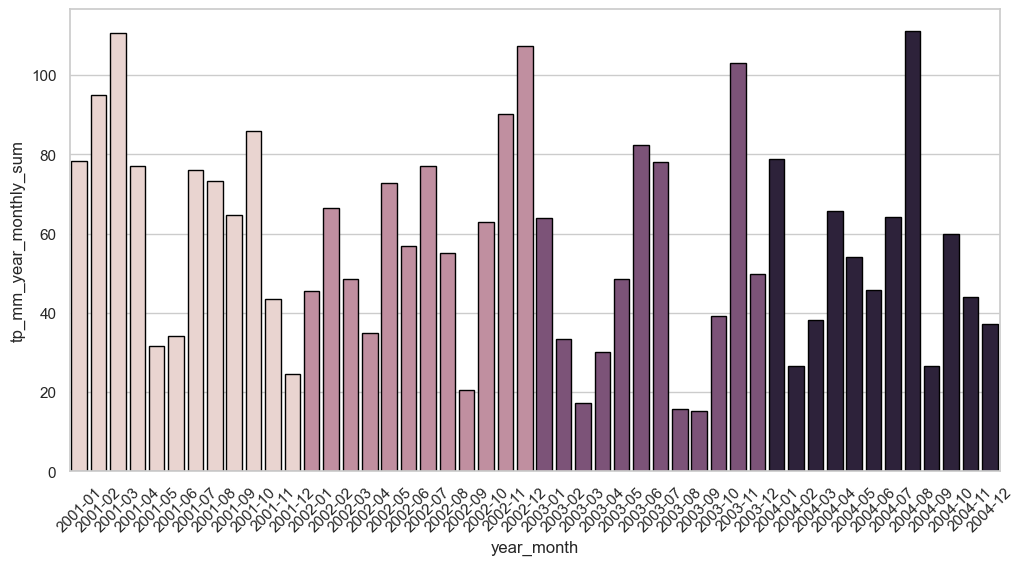

In [8]:
fig_size = (12,6)

start_year = 2001
end_year = 2004
orientation = 45
feature = 'tp_mm_year_monthly_sum'

df_plot = df_tp_monthly[(df_tp_monthly['year'] >= start_year) & (df_tp_monthly['year'] <= end_year)]

sns.set_theme(style="whitegrid")
plt.figure(figsize=fig_size)

ax = sns.barplot(
    data=df_plot,
    x='year_month',
    y=feature,
    hue='year',
    edgecolor='black',
    errorbar=None,
    legend=False,
    );
   

new_labels = df_plot['year_month_display']
ax.set_xticks(range(len(new_labels)))
ax.set_xticklabels(new_labels, rotation=45, ha='center');

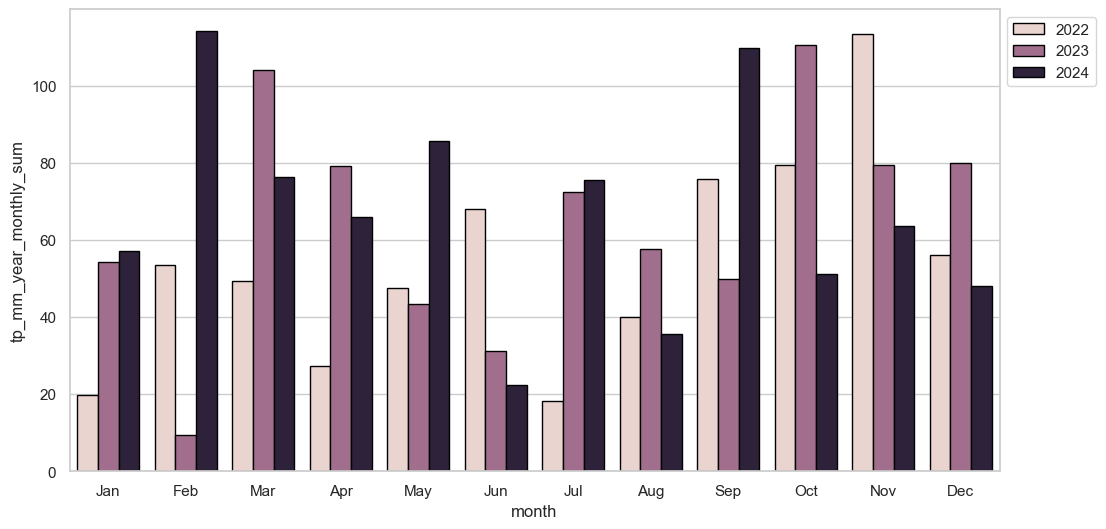

In [37]:
fig_size = (12,6)

start_year = 2022
end_year = 2024
orientation = 45
feature = 'tp_mm_year_monthly_sum'

df_plot = df_tp_monthly[(df_tp_monthly['year'] >= start_year) & (df_tp_monthly['year'] <= end_year)]

sns.set_theme(style="whitegrid")
plt.figure(figsize=fig_size)

ax = sns.barplot(
    data=df_plot,
    x='month',
    y=feature,
    hue='year',
    edgecolor='black',
    errorbar=None,
    legend=True,
    );

# Move legend to the right
plt.legend(bbox_to_anchor=(1., 1), loc='upper left');

In [9]:
df_tp_daily.columns

Index(['date', 'year', 'month', 'day', 'tp_daily_sum', 'tp_daily_mean',
       'tp_daily_std', 'tp_daily_median', 'tp_daily_max', 'tp_daily_min',
       'tp_mm_daily_sum', 'tp_mm_daily_mean', 'tp_mm_daily_std',
       'tp_mm_daily_median', 'tp_mm_daily_min', 'tp_mm_daily_max', 'month_int',
       'rainy_day'],
      dtype='object')

In [10]:
import calendar

month_order = list(calendar.month_abbr)[1:]
df_tp_daily['month'] = pd.Categorical(df_tp_daily['month'], categories=month_order, ordered=True)

(df_tp_daily
 .groupby('month', observed = True)
 .agg(
#     month = ('month', 'first'),
     tp_mm_monthly_sum = ('tp_mm_daily_sum', 'sum'),
     tp_mm_monthly_mean = ('tp_mm_daily_sum', 'mean')
 )
 .reset_index()
 .sort_values('month')
)

,month,tp_mm_monthly_sum,tp_mm_monthly_mean
0,Jan,1627.616011,1.944583
1,Feb,1452.476222,1.903639
2,Mar,1323.541523,1.581292
3,Apr,1322.722392,1.632991
4,May,1621.847608,1.937691
5,Jun,1642.237322,2.060524
6,Jul,1699.545476,2.108617
7,Aug,1805.807897,2.240456
8,Sep,1281.012971,1.642324
9,Oct,1777.830990,2.205746


In [11]:
# The correct approach for mean monthly precipitation
monthly_precipitation = df_tp_daily.groupby(['year', 'month'])['tp_mm_daily_sum'].sum().reset_index()
monthly_precipitation.columns = ['year', 'month', 'monthly_total']

# Convert month to categorical for proper ordering
month_order = list(calendar.month_abbr)[1:]
monthly_precipitation['month'] = pd.Categorical(monthly_precipitation['month'], 
                                              categories=month_order, ordered=True)

# Calculate mean monthly precipitation across years
mean_monthly_precip = monthly_precipitation.groupby('month')['monthly_total'].mean()
print(mean_monthly_precip)

month
Jan    60.282074
Feb    53.795416
Mar    49.020056
Apr    48.989718
May    60.068430
Jun    60.823605
Jul    62.946129
Aug    66.881774
Sep    47.444925
Oct    65.845592
Nov    63.529683
Dec    60.113567
Name: monthly_total, dtype: float64


In [12]:
## this is the daily mean for Jan

df_tp_daily[df_tp_daily['month'] == 'Jan']['tp_mm_daily_sum'].mean()

1.9445830483150772

In [13]:
df_step_1 = (df_tp_daily
             .groupby(['year','month'], observed = True)
             .agg(
                 tp_mm_sum = ('tp_mm_daily_sum', 'sum'),
                 tp_mm_daily_mean = ('tp_mm_daily_sum', 'mean')
                 ).reset_index()
                 )

In [14]:
df_step_1.head()

,year,month,tp_mm_sum,tp_mm_daily_mean
0,1999,Jan,74.123183,2.391070
1,1999,Feb,24.590958,0.878248
2,1999,Mar,39.160769,1.263251
3,1999,Apr,53.560422,1.785347
4,1999,May,34.500789,1.112929


In [15]:
(df_step_1
 .groupby('month', observed = True)
 .agg(
     tp_mm_monthly_sum = ('tp_mm_sum', 'sum'),
     tp_mm_monthly_mean = ('tp_mm_sum', 'mean'),
     tp_mm_monthly_std = ('tp_mm_sum', 'std')
 ).reset_index()
 )


,month,tp_mm_monthly_sum,tp_mm_monthly_mean,tp_mm_monthly_std
0,Jan,1627.616011,60.282074,25.657463
1,Feb,1452.476222,53.795416,27.860694
2,Mar,1323.541523,49.020056,26.969564
3,Apr,1322.722392,48.989718,28.732181
4,May,1621.847608,60.068430,27.161991
5,Jun,1642.237322,60.823605,36.801998
6,Jul,1699.545476,65.367134,25.526541
7,Aug,1805.807897,69.454150,28.262450
8,Sep,1281.012971,49.269730,23.500685
9,Oct,1777.830990,68.378115,33.856178


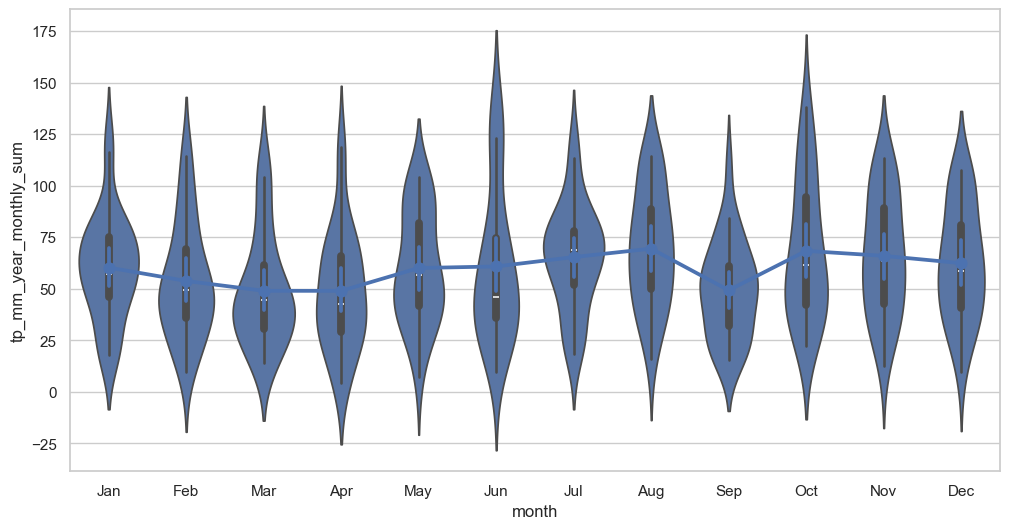

In [17]:
fig_size = (12,6)

sns.set_theme(style="whitegrid")
plt.figure(figsize=fig_size)

df_plot_boxplot = df_tp_monthly[['year', 'month', 'tp_mm_year_monthly_sum']]

sns.violinplot(
    data = df_plot_boxplot,
    x = 'month',
    y = 'tp_mm_year_monthly_sum'
);

sns.pointplot(x = 'month', y='tp_mm_year_monthly_sum', data=df_plot_boxplot, estimator=np.mean);

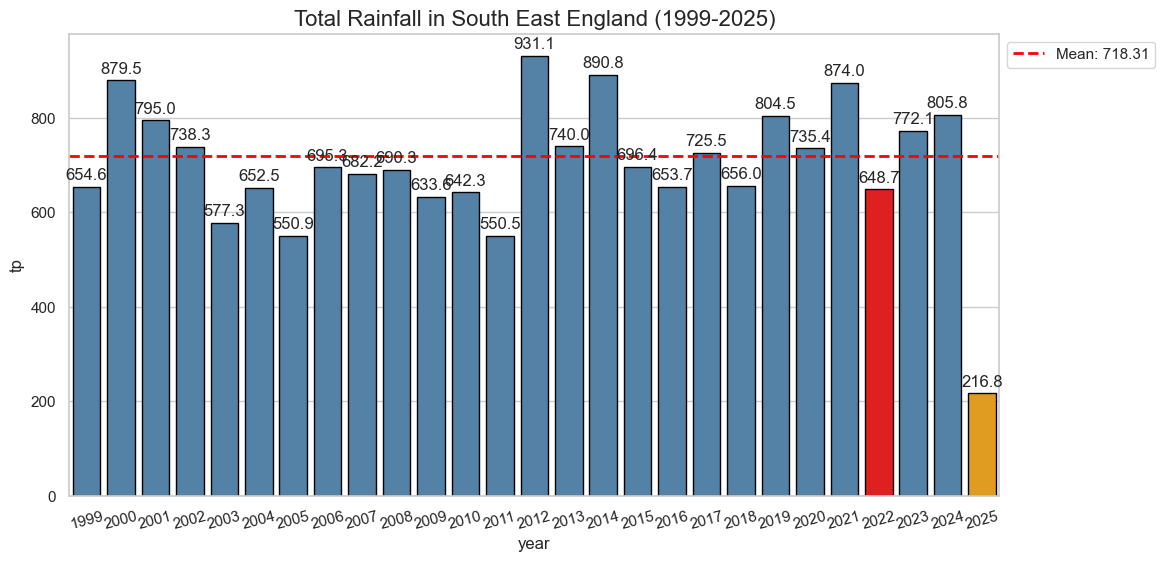

In [229]:
from src.data_plotting import plot_rainfall

df_plot = (df_tp_daily
 .groupby(['year'], observed = True)
 .agg(
     tp = ('tp_mm_daily_sum', 'sum'),
     tp_daily_mean = ('tp_mm_daily_sum', 'mean')
 ).reset_index()
)

plot_rainfall(
    df_plot,
    start_year=1999,
    latest_year=2025,
    feature = 'tp',
    rotation_x_label=15
)

In [107]:
df_tp_daily.head(3)

,date,year,month,day,tp_daily_sum,tp_daily_mean,tp_daily_std,tp_daily_median,tp_daily_max,tp_daily_min,tp_mm_daily_sum,tp_mm_daily_mean,tp_mm_daily_std,tp_mm_daily_median,tp_mm_daily_min,tp_mm_daily_max
0,1999-01-01,1999,Jan,1,0.000115,0.000005,0.000010,0.000000,0.000034,0.0,0.114918,0.004788,0.010305,0.000000,0.0,0.034237
1,1999-01-02,1999,Jan,2,0.003636,0.000151,0.000345,0.000007,0.001358,0.0,3.635501,0.151479,0.344832,0.006628,0.0,1.358417
2,1999-01-03,1999,Jan,3,0.007048,0.000294,0.000489,0.000011,0.001751,0.0,7.048499,0.293687,0.489040,0.011015,0.0,1.751140


In [96]:
(df_tp_monthly
 .groupby('year', observed = True)['tp_mm_year_monthly_sum']
 .sum()
 )[:5]

year
1999    654.551079
2000    879.546671
2001    795.023448
2002    738.264118
2003    577.337717
Name: tp_mm_year_monthly_sum, dtype: float64

In [118]:
ffolder = './output/tp/london/'
fname = 'london_tp_hourly_data.pkl'
foutput = fname.split('_')
output_fname = ffolder + foutput[0] + '_' + foutput[1] + '_' + 'daily_data.pkl'
output_fname

df_test = pd.read_pickle(output_fname)

def shift_month_grouping_v2(df, shift_day=15):
    """
    Alternative approach using datetime arithmetic
    """
    df = df.copy()
    
    # Subtract (shift_day - 1) days from each date
    df['shifted_date'] = df['date'] - pd.Timedelta(days=shift_day-1)
    
    # Extract year-month from the shifted date
    df['shifted_month_group'] = df['shifted_date'].dt.to_period('M')
    
    return df

# Usage:
df_shifted = shift_month_grouping_v2(df_test, shift_day=15)
# monthly_precip = df_shifted.groupby('shifted_month_group')['tp_mm'].agg(['sum', 'mean', 'count'])


In [121]:
df_shifted.columns

Index(['date', 'year', 'month', 'day', 'tp_daily_sum', 'tp_daily_mean',
       'tp_daily_std', 'tp_daily_median', 'tp_daily_max', 'tp_daily_min',
       'tp_mm_daily_sum', 'tp_mm_daily_mean', 'tp_mm_daily_std',
       'tp_mm_daily_median', 'tp_mm_daily_min', 'tp_mm_daily_max',
       'shifted_date', 'shifted_month_group'],
      dtype='object')

In [141]:
monthly_shifted_precip = df_shifted.groupby('shifted_month_group')['tp_mm_daily_sum'].agg(['sum', 'mean', 'count']).reset_index()
monthly_shifted_precip['year'] = monthly_shifted_precip['shifted_month_group'].astype(str).str[:4]
monthly_shifted_precip['month'] = monthly_shifted_precip['shifted_month_group'].astype(str).str[-2:]
monthly_shifted_precip.head()

,shifted_month_group,sum,mean,count,year,month
0,1998-12,34.863477,2.490248,14,1998,12
1,1999-01,47.660629,1.537440,31,1999,01
2,1999-02,35.021438,1.250766,28,1999,02
3,1999-03,38.049161,1.227392,31,1999,03
4,1999-04,53.721401,1.790713,30,1999,04


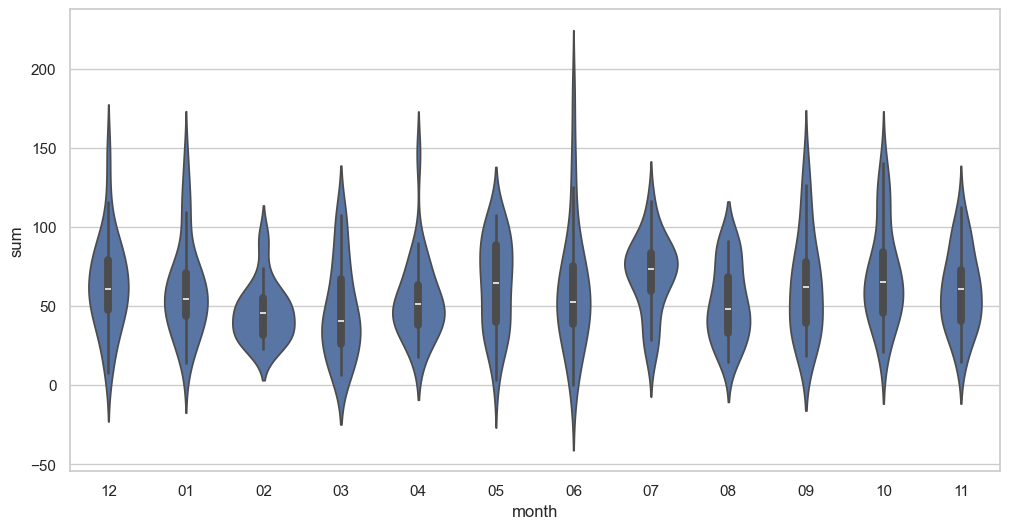

In [146]:
fig_size = (12,6)

sns.set_theme(style="whitegrid")
plt.figure(figsize=fig_size)

df_plot_boxplot = monthly_shifted_precip[['year', 'month', 'sum']]

sns.violinplot(
    data = df_plot_boxplot,
    x = 'month',
    y = 'sum'
);

In [145]:
df_plot_boxplot

,year,month,sum
0,1998,12,34.863477
1,1999,01,47.660629
2,1999,02,35.021438
3,1999,03,38.049161
4,1999,04,53.721401
...,...,...,...
314,2025,02,35.920561
315,2025,03,9.835699
316,2025,04,35.829207
317,2025,05,43.212429


In [138]:
monthly_precip['shifted_month_group'].astype(str).str[:4]

0      1998
1      1999
2      1999
3      1999
4      1999
       ... 
314    2025
315    2025
316    2025
317    2025
318    2025
Name: shifted_month_group, Length: 319, dtype: object

In [139]:
monthly_precip['shifted_month_group'].astype(str).str[-2:]

0      12
1      01
2      02
3      03
4      04
       ..
314    02
315    03
316    04
317    05
318    06
Name: shifted_month_group, Length: 319, dtype: object

In [110]:
ffolder = './output/tp/london/'
fname = 'london_tp_hourly_data.pkl'
foutput = fname.split('_')
output_fname = ffolder + foutput[0] + '_' + foutput[1] + '_' + 'daily_data.pkl'
output_fname

df_test = pd.read_pickle(output_fname)
df_test.head()

,date,year,month,day,tp_daily_sum,tp_daily_mean,tp_daily_std,tp_daily_median,tp_daily_max,tp_daily_min,tp_mm_daily_sum,tp_mm_daily_mean,tp_mm_daily_std,tp_mm_daily_median,tp_mm_daily_min,tp_mm_daily_max
0,1999-01-01,1999,Jan,1,0.000115,4.788235e-06,0.000010,0.000000,0.000034,0.0,0.114918,0.004788,0.010305,0.000000,0.0,0.034237
1,1999-01-02,1999,Jan,2,0.003636,1.514792e-04,0.000345,0.000007,0.001358,0.0,3.635501,0.151479,0.344832,0.006628,0.0,1.358417
2,1999-01-03,1999,Jan,3,0.007048,2.936874e-04,0.000489,0.000011,0.001751,0.0,7.048499,0.293687,0.489040,0.011015,0.0,1.751140
3,1999-01-04,1999,Jan,4,0.000633,2.638104e-05,0.000043,0.000008,0.000185,0.0,0.633145,0.026381,0.043223,0.008392,0.0,0.185108
4,1999-01-05,1999,Jan,5,0.000022,9.179096e-07,0.000002,0.000000,0.000006,0.0,0.022030,0.000918,0.001569,0.000000,0.0,0.006008


In [113]:
df_test['day'] < 15

0        True
1        True
2        True
3        True
4        True
        ...  
9660     True
9661     True
9662    False
9663    False
9664    False
Name: day, Length: 9665, dtype: bool

In [94]:
df_tp_monthly.columns

Index(['year', 'month', 'tp_year_monthly_sum', 'tp_year_monthly_mean',
       'tp_year_monthly_std', 'tp_year_monthly_median', 'tp_year_monthly_max',
       'tp_year_monthly_min', 'tp_mm_year_monthly_sum',
       'tp_mm_year_monthly_mean', 'tp_mm_year_monthly_std',
       'tp_mm_year_monthly_median', 'tp_mm_year_monthly_min',
       'tp_mm_year_monthly_max', 'year_month', 'year_month_display'],
      dtype='object')

In [50]:
1627/27

60.25925925925926

In [ ]:
df_tp_monthly = (df_tp_daily
                 .groupby(['year', 'month'])
                 .agg(
                     tp_monthly_sum = ('tp_daily_sum', 'sum'),
                     tp_monthly_mean = ('tp_daily_mean', 'mean'),
                     tp_monthly_std = ('tp_daily_std', 'std'),
                     tp_monthly_median = ('tp_daily_median', 'median'),
                     tp_monthly_max = ('tp_daily_max', 'max'),
                     tp_monthly_min = ('tp_daily_min', 'min'),
                     
                     tp_mm_monthly_sum = ('tp_mm_daily_sum', 'sum'),
                     tp_mm_monthly_mean = ('tp_mm_daily_mean', 'mean'),
                     tp_mm_monthly_std = ('tp_mm_daily_std', 'std'),
                     tp_mm_monthly_median = ('tp_mm_daily_median', 'median'),
                     tp_mm_monthly_min = ('tp_mm_daily_min', 'min'),
                     tp_mm_monthly_max = ('tp_mm_daily_max', 'max')
                     )
                     .reset_index()
                     )

df_tp_monthly['year_month'] = pd.to_datetime(df_tp_monthly['year'].astype(str) + '-' + df_tp_monthly['month'], format='%Y-%b')
df_tp_monthly['year_month_display'] = df_tp_monthly['year_month'].dt.strftime('%Y-%m')
df_tp_monthly.sort_values('year_month', inplace=True)

In [ ]:
fig_size = (12,6)

start_year = 2001
end_year = 2004
orientation = 45
feature = 'tp_mm_monthly_sum'

df_plot = df_tp_monthly[(df_tp_monthly['year'] >= start_year) & (df_tp_monthly['year'] <= end_year)]

sns.set_theme(style="whitegrid")
plt.figure(figsize=fig_size)

ax = sns.barplot(
    data=df_plot,
    x='year_month',
    y=feature,
    hue='year',
    edgecolor='black',
    errorbar=None,
    legend=False,
    );
   

new_labels = df_plot['year_month_display']
ax.set_xticklabels(new_labels, rotation=45, ha='center');

In [ ]:
fig_size = (12,6)

start_year = 2022
end_year = 2024
orientation = 45
feature = 'tp_mm_monthly_sum'

df_plot = df_tp_monthly[(df_tp_monthly['year'] >= start_year) & (df_tp_monthly['year'] <= end_year)]

sns.set_theme(style="whitegrid")
plt.figure(figsize=fig_size)

ax = sns.barplot(
    data=df_plot,
    x='month',
    y=feature,
    hue='year',
    edgecolor='black',
    errorbar=None,
    legend=True,
    );
   

# new_labels = df_plot['year_month_display']
# ax.set_xticklabels(new_labels, rotation=45, ha='center');

### First months aggregate

In [239]:
df_tp_daily = create_daily_aggregate(rainyday_threshold=0.05)

city = london, var = tp
(231950, 8)
columns = Index(['valid_time', 'year', 'month', 'day', 'tp', 'tp_mm', 'hour_of_day',
       'month int'],
      dtype='object')
./output/tp/london/london_tp_daily_data.pkl


In [246]:
def aggregate_early_months(df_data, n_month = 4):
    df_tp_daily_early_months = df_data[df_tp_daily['month_int'] <= n_month].copy()
    
    yearly_early_aggregate = (
        df_tp_daily_early_months.groupby('year', observed = True)
        .agg(
            tp_mm_yearly_sum = ('tp_mm_daily_sum', 'sum'),
            tp_mm_daily_mean = ('tp_mm_daily_sum', 'mean'),
            tp_mm_daily_std = ('tp_mm_daily_sum', 'std'),
            tp_mm_daily_median = ('tp_mm_daily_sum', 'median'),
            tp_mm_daily_min = ('tp_mm_daily_sum', 'min'),
            tp_mm_daily_max = ('tp_mm_daily_sum', 'max')
            )
            .reset_index()
            )
    return(yearly_early_aggregate)

In [253]:
aggregate_5_months = aggregate_early_months(df_tp_daily, n_month=5)

In [254]:
aggregate_5_months.head()

,year,tp_mm_yearly_sum,tp_mm_daily_mean,tp_mm_daily_std,tp_mm_daily_median,tp_mm_daily_min,tp_mm_daily_max
0,1999,225.936120,1.496266,2.148043,0.597335,0.0,10.927109
1,2000,332.221400,2.185667,3.493179,0.622511,0.0,19.291871
2,2001,392.845149,2.601624,3.842069,0.899126,0.0,21.153546
3,2002,268.323773,1.776979,2.737675,0.534440,0.0,13.790979
4,2003,193.422517,1.280944,2.545011,0.137424,0.0,15.746749


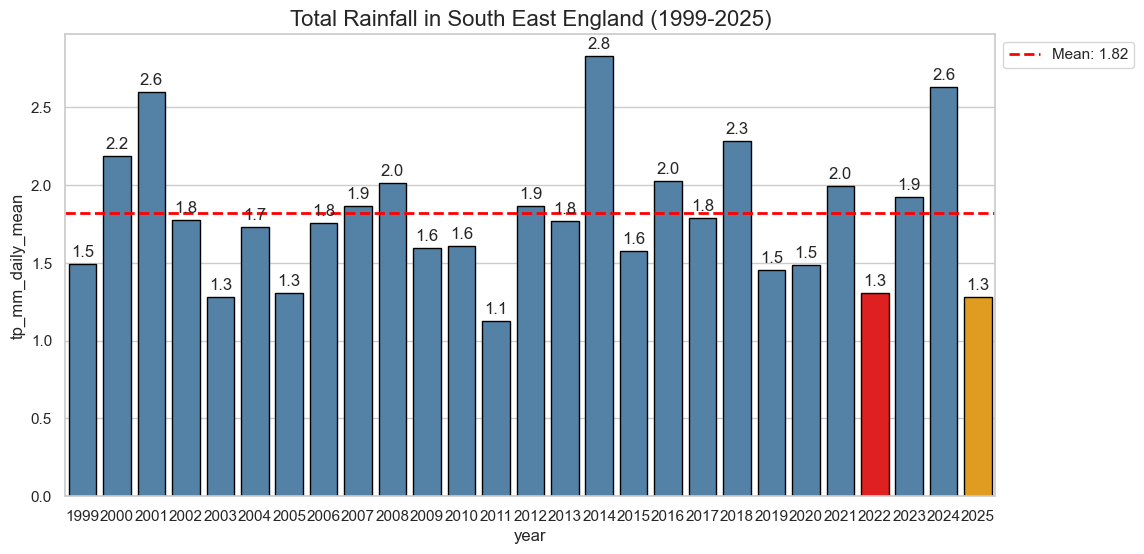

In [257]:
plot_rainfall(
    aggregate_5_months,
    start_year=1999,
    latest_year=2025,
    feature='tp_mm_daily_mean'
)

1021.9999999999999

In [ ]:
aggregate_t

### Days without raining 

In [221]:
df_tp_daily = create_daily_aggregate(rainyday_threshold=0.05)
df_tp_daily.head()

city = london, var = tp
(231950, 8)
columns = Index(['valid_time', 'year', 'month', 'day', 'tp', 'tp_mm', 'hour_of_day',
       'month int'],
      dtype='object')
./output/tp/london/london_tp_daily_data.pkl


,date,year,month,day,tp_daily_sum,tp_daily_mean,tp_daily_std,tp_daily_median,tp_daily_max,tp_daily_min,tp_mm_daily_sum,tp_mm_daily_mean,tp_mm_daily_std,tp_mm_daily_median,tp_mm_daily_min,tp_mm_daily_max,rainy_day
0,1999-01-01,1999,Jan,1,0.000115,4.788235e-06,0.000010,0.000000,0.000034,0.0,0.114918,0.004788,0.010305,0.000000,0.0,0.034237,1
1,1999-01-02,1999,Jan,2,0.003636,1.514792e-04,0.000345,0.000007,0.001358,0.0,3.635501,0.151479,0.344832,0.006628,0.0,1.358417,1
2,1999-01-03,1999,Jan,3,0.007048,2.936874e-04,0.000489,0.000011,0.001751,0.0,7.048499,0.293687,0.489040,0.011015,0.0,1.751140,1
3,1999-01-04,1999,Jan,4,0.000633,2.638104e-05,0.000043,0.000008,0.000185,0.0,0.633145,0.026381,0.043223,0.008392,0.0,0.185108,1
4,1999-01-05,1999,Jan,5,0.000022,9.179096e-07,0.000002,0.000000,0.000006,0.0,0.022030,0.000918,0.001569,0.000000,0.0,0.006008,0


In [226]:
df_tp_daily_0 = create_daily_aggregate(rainyday_threshold=0.0)
df_tp_daily_0[df_tp_daily_0['rainy_day'] == 0][['year','rainy_day']].value_counts()[:10].reset_index()

city = london, var = tp
(231950, 8)
columns = Index(['valid_time', 'year', 'month', 'day', 'tp', 'tp_mm', 'hour_of_day',
       'month int'],
      dtype='object')
./output/tp/london/london_tp_daily_data.pkl


,year,rainy_day,count
0,2003,0,59
1,2020,0,52
2,2022,0,47
3,2019,0,44
4,2018,0,44
5,2017,0,39
6,2023,0,36
7,2012,0,34
8,2014,0,34
9,2006,0,34


In [230]:
df_tp_daily[df_tp_daily['rainy_day'] == 0][['year','rainy_day']].value_counts()[:15].reset_index()

,year,rainy_day,count
0,2003,0,145
1,2023,0,120
2,2020,0,116
3,2018,0,114
4,2011,0,114
5,2019,0,111
6,2009,0,109
7,2007,0,108
8,2005,0,107
9,2022,0,103


99

In [ ]:
test[test['tp_mm'] > 13.]

In [ ]:
test[(test['year'] == 2013) & (test['month int'] == 7)]['tp_mm'].sum()

In [ ]:
time_delta = (london_tp_hourly['valid_time'].max() - london_tp_hourly['valid_time'].min())
time_delta.components.days *24 +  time_delta.components.hours + 1

In [ ]:
from src.data_manipulation import transform_data_datetime

london_tp_hourly['hour_of_day'] = london_tp_hourly['valid_time'].dt.hour
london_tp_hourly_test = transform_data_datetime(london_tp_hourly, date_column='valid_time')

In [ ]:
london_tp_hourly_test.head()

In [ ]:
london_tp_daily_test = (london_tp_hourly_test
                        .groupby('valid_time')
                        .agg(
                            tp_sum = ('tp', 'sum'),
                            tp_min = ('tp', 'min'),
                            tp_max = ('tp', 'max'),
                            tp_mm_sum = ('tp_mm', 'sum'),
                            tp_mm_min = ('tp_mm', 'min'),
                            tp_mm_max = ('tp_mm', 'max'),
                            year = ('year', 'first'),
                            month_int = ('month int', 'first'),
                            month = ('month', 'first'),
                            day = ('day', 'first')
                       )
                       .reset_index()
                       )

london_tp_daily_test.head()

In [ ]:
london_tp_hourly['valid_time'].dt.hour

In [ ]:
london_tp_hourly['valid_date'] = london_tp_hourly['valid_time'].dt.date

In [ ]:
london_tp_daily = (london_tp_hourly
                   .groupby('valid_date')[['tp', 'tp_mm']]
                   .agg(
                       tp_sum = ('tp', 'sum'),
                       tp_min = ('tp', 'min'),
                       tp_max = ('tp', 'max'),
                       tp_mm_sum = ('tp_mm', 'sum'),
                       tp_mm_min = ('tp_mm', 'min'),
                       tp_mm_max = ('tp_mm', 'max')
                       )
                       .reset_index()
                       )

london_tp_daily.head()

In [ ]:
london_tp_daily['year'] = london_tp_daily

In [ ]:
london_tp_daily[london_tp_daily['tp_max'] > 0]

In [ ]:
file_path = './data/ERA5/data_puglia_tp_2025.grib'
output_path = './output/'
city_name = 'bari'
city_lat = 41.14043890868558  # Bari latitude
city_lon = 16.86619063277282  # Bari longitude

df_test_bari = process_grib_file(grib_file_path = file_path,
                            output_csv_path=output_path,
                            city_name=city_name,
                            city_lat=city_lat,
                            city_lon=city_lon)

In [ ]:
# Lecce 40.35654102220363, 18.17311913754415

file_path = './data/ERA5/data_puglia_tp_2025.grib'
output_path = './output/'
city_name = 'lecce'
city_lat = 40.35654102220363  # Lecce latitude
city_lon = 18.17311913754415  # Lecce longitude

df_test_lecce = process_grib_file(grib_file_path = file_path,
                                  output_csv_path=output_path,
                                  city_name=city_name,
                                  city_lat=city_lat,
                                  city_lon=city_lon)

In [ ]:
# Working for London coordinates

import xarray as xr
import pandas as pd
import numpy as np
from pathlib import Path

def grib_to_csv_london(grib_file_path, output_csv_path=None):
    """
    Read GRIB file, extract data for London coordinates, and save as CSV.
    
    Parameters:
    grib_file_path (str): Path to the GRIB file
    output_csv_path (str): Path for output CSV file (optional)
    
    Returns:
    pandas.DataFrame: DataFrame with the extracted data
    """
    
    # London coordinates
    london_lat = 51.5074
    london_lon = -0.1278  # Note: GRIB files often use 0-360 longitude
    london_lon_360 = 359.8722  # London longitude in 0-360 format
    
    print(f"Reading GRIB file: {grib_file_path}")
    
    try:
        # Open GRIB file with xarray
        ds = xr.open_dataset(grib_file_path, engine='cfgrib')
        
        print("Dataset loaded successfully!")
        print(f"Dataset dimensions: {dict(ds.dims)}")
        print(f"Dataset variables: {list(ds.data_vars)}")
        print(f"Dataset coordinates: {list(ds.coords)}")
        
        # Check longitude format (0-360 vs -180-180)
        lon_min = ds.longitude.min().values
        lon_max = ds.longitude.max().values
        print(f"Longitude range: {lon_min} to {lon_max}")
        
        # Use appropriate London longitude based on the dataset's longitude format
        if lon_max > 180:
            target_lon = london_lon_360
            print(f"Using 0-360 longitude format: {target_lon}")
        else:
            target_lon = london_lon
            print(f"Using -180-180 longitude format: {target_lon}")
        
        # Find nearest grid point to London
        lat_idx = np.abs(ds.latitude - london_lat).argmin()
        lon_idx = np.abs(ds.longitude - target_lon).argmin()
        
        actual_lat = ds.latitude[lat_idx].values
        actual_lon = ds.longitude[lon_idx].values
        
        print(f"Target coordinates: ({london_lat}, {target_lon})")
        print(f"Nearest grid point: ({actual_lat}, {actual_lon})")
        
        # Extract data for London coordinates
        london_data = ds.isel(latitude=lat_idx, longitude=lon_idx)
        
        # Convert to pandas DataFrame
        df_list = []
        
        for var_name in london_data.data_vars:
            var_data = london_data[var_name]
            
            # Handle different time dimensions
            if 'time' in var_data.dims:
                # Create DataFrame with time index
                df_var = var_data.to_dataframe().reset_index()
                df_var = df_var.rename(columns={var_name: var_name})
                df_list.append(df_var)
            elif 'valid_time' in var_data.dims:
                # Handle valid_time dimension
                df_var = var_data.to_dataframe().reset_index()
                df_var = df_var.rename(columns={var_name: var_name})
                df_list.append(df_var)
            else:
                # Single value variables
                df_var = pd.DataFrame({
                    var_name: [var_data.values],
                    'latitude': [actual_lat],
                    'longitude': [actual_lon]
                })
                df_list.append(df_var)
        
        # Combine all variables into one DataFrame
        if len(df_list) > 1:
            # Merge on common columns (time, latitude, longitude)
            df = df_list[0]
            for df_var in df_list[1:]:
                common_cols = set(df.columns) & set(df_var.columns)
                if common_cols:
                    df = pd.merge(df, df_var, on=list(common_cols), how='outer')
                else:
                    # If no common columns, concatenate side by side
                    df = pd.concat([df, df_var], axis=1)
        else:
            df = df_list[0]
        
        # Add metadata columns
        df['actual_latitude'] = actual_lat
        df['actual_longitude'] = actual_lon
        df['target_latitude'] = london_lat
        df['target_longitude'] = target_lon
        
        # Sort by time if time column exists
        time_cols = [col for col in df.columns if 'time' in col.lower()]
        if time_cols:
            df = df.sort_values(time_cols[0])
        
        print(f"DataFrame shape: {df.shape}")
        print(f"DataFrame columns: {list(df.columns)}")
        print("\nFirst few rows:")
        print(df.head())
        
        # Save to CSV
        if output_csv_path is None:
            output_csv_path = Path(grib_file_path).stem + "_london_data.csv"
        
        df.to_csv(output_csv_path, index=False)
        print(f"\nData saved to: {output_csv_path}")
        
        return df
        
    except Exception as e:
        print(f"Error processing GRIB file: {e}")
        print("Make sure you have the required packages installed:")
        print("pip install xarray cfgrib pandas numpy")
        raise

def main():
    # Example usage
    grib_file = "./data/ERA5/ERA5_hourly_data_on_single_levels_from_2014_to_2021.grib"  # Replace with your GRIB file path
    output_csv = "./output/ERA5_hourly_data_on_single_levels_from_2014_to_2021.csv"  # Replace with desired output path
    
    # Check if file exists
    if not Path(grib_file).exists():
        print(f"GRIB file not found: {grib_file}")
        print("Please update the 'grib_file' variable with the correct path to your GRIB file.")
        return
    
    # Process the file
    try:
        df = grib_to_csv_london(grib_file, output_csv)
        
        # Display summary statistics
        print("\n" + "="*50)
        print("SUMMARY")
        print("="*50)
        print(f"Total records: {len(df)}")
        
        # Show time range if available
        time_cols = [col for col in df.columns if 'time' in col.lower()]
        if time_cols:
            time_col = time_cols[0]
            print(f"Time range: {df[time_col].min()} to {df[time_col].max()}")
        
        print(f"Variables extracted: {[col for col in df.columns if col not in ['latitude', 'longitude', 'actual_latitude', 'actual_longitude', 'target_latitude', 'target_longitude'] + time_cols]}")
        
        # Load the CSV back into pandas to verify
        print("\n" + "="*50)
        print("VERIFICATION - Loading CSV back into pandas:")
        print("="*50)
        df_loaded = pd.read_csv(output_csv)
        print(f"Loaded DataFrame shape: {df_loaded.shape}")
        print("DataFrame info:")
        print(df_loaded.info())
        
    except Exception as e:
        print(f"Failed to process GRIB file: {e}")

if __name__ == "__main__":
    main()

In [ ]:
df_data = pd.read_csv("./output/ERA5_hourly_data_on_single_levels_from_2014_to_2021.csv")
print(df_data.shape)
df_data.head()

In [ ]:
140-80

In [ ]:
df_data = pd.read_csv("./output/ERA5_hourly_data_on_single_levels_from_1940_to_present.csv")
df_data.tail()

In [ ]:
df_data.shape

In [ ]:
df_data['year'] = pd.to_datetime(df_data['time'], errors='coerce').dt.year


In [ ]:
(df_data
 .groupby('year', observed=True)['tp']
 .sum()
)

### NC files

In [ ]:
# V4 

import xarray as xr
import pandas as pd
import numpy as np
from pathlib import Path

def netcdf_to_csv_london(nc_file_path, output_csv_path=None):
    """
    Read NetCDF file, extract precipitation data for London coordinates, and save as CSV.
    
    Parameters:
    nc_file_path (str): Path to the NetCDF file
    output_csv_path (str): Path for output CSV file (optional)
    
    Returns:
    pandas.DataFrame: DataFrame with the extracted data
    """
    
    # London coordinates
    london_lat = 51.5074
    london_lon = -0.1278
    
    print(f"Reading NetCDF file: {nc_file_path}")
    
    try:
        # Open NetCDF file with xarray
        ds = xr.open_dataset(nc_file_path)
        
        print("Dataset loaded successfully!")
        print(f"Dataset dimensions: {dict(ds.dims)}")
        print(f"Dataset variables: {list(ds.data_vars)}")
        print(f"Dataset coordinates: {list(ds.coords)}")
        
        # Display dataset info
        print("\nDataset overview:")
        print(ds)
        
        # Check coordinate names (common variations)
        lat_names = ['lat', 'latitude', 'y', 'projection_y_coordinate']
        lon_names = ['lon', 'longitude', 'x', 'projection_x_coordinate']
        time_names = ['time', 'time_bnds', 'yyyymm']
        
        # Find actual coordinate names in the dataset
        lat_coord = None
        lon_coord = None
        time_coord = None
        
        for name in lat_names:
            if name in ds.coords or name in ds.dims:
                lat_coord = name
                break
                
        for name in lon_names:
            if name in ds.coords or name in ds.dims:
                lon_coord = name
                break
                
        for name in time_names:
            if name in ds.coords or name in ds.dims:
                time_coord = name
                break
        
        print(f"\nIdentified coordinates:")
        print(f"Latitude coordinate: {lat_coord}")
        print(f"Longitude coordinate: {lon_coord}")
        print(f"Time coordinate: {time_coord}")
        
        if lat_coord is None or lon_coord is None:
            print("Warning: Could not identify latitude/longitude coordinates")
            print("Available coordinates:", list(ds.coords))
            return None
        
        # Check coordinate ranges
        if lat_coord in ds.coords:
            lat_min = ds.coords[lat_coord].min().values
            lat_max = ds.coords[lat_coord].max().values
            print(f"Latitude range: {lat_min} to {lat_max}")
        
        if lon_coord in ds.coords:
            lon_min = ds.coords[lon_coord].min().values
            lon_max = ds.coords[lon_coord].max().values
            print(f"Longitude range: {lon_min} to {lon_max}")
        
        # Handle projected coordinates (if using OSGB or similar)
        if 'projection' in str(ds.coords) or lat_coord in ['y', 'projection_y_coordinate']:
            print("\nDetected projected coordinates (likely OSGB)")
            print("You may need to convert London lat/lon to the projection coordinates")
            print("For now, finding nearest grid point in projected space...")
        
        # Define region around London (in degrees)
        region_size = 0.5  # degrees (approximately 50km at London's latitude)
        
        # Define bounding box around London
        lat_min = london_lat - region_size
        lat_max = london_lat + region_size
        lon_min = london_lon - region_size
        lon_max = london_lon + region_size
        
        print(f"\nExtracting region around London:")
        print(f"Latitude range: {lat_min:.3f} to {lat_max:.3f}")
        print(f"Longitude range: {lon_min:.3f} to {lon_max:.3f}")
        
        # Find grid indices for the region
        if lat_coord in ds.coords and lon_coord in ds.coords:
            # Handle 2D coordinate arrays (common in projected datasets)
            lat_data = ds.coords[lat_coord]
            lon_data = ds.coords[lon_coord]
            
            if lat_data.ndim == 2 and lon_data.ndim == 2:
                # 2D coordinate arrays - find region
                print("Using 2D coordinate arrays to find region")
                
                # Find points within the bounding box
                within_region = ((lat_data >= lat_min) & (lat_data <= lat_max) & 
                               (lon_data >= lon_min) & (lon_data <= lon_max))
                
                # Find the bounding indices of the region
                y_indices, x_indices = np.where(within_region)
                
                if len(y_indices) == 0:
                    print("No grid points found in the specified region!")
                    return None
                
                y_min_idx = y_indices.min()
                y_max_idx = y_indices.max()
                x_min_idx = x_indices.min()
                x_max_idx = x_indices.max()
                
                print(f"Found {len(y_indices)} grid points in region")
                print(f"Grid index ranges: y={y_min_idx}-{y_max_idx}, x={x_min_idx}-{x_max_idx}")
                
                # Store the slice ranges for extraction
                y_slice = slice(y_min_idx, y_max_idx + 1)
                x_slice = slice(x_min_idx, x_max_idx + 1)
                
                # Get actual coordinate bounds of extracted region
                region_lat_min = lat_data[y_min_idx:y_max_idx+1, x_min_idx:x_max_idx+1].min().values
                region_lat_max = lat_data[y_min_idx:y_max_idx+1, x_min_idx:x_max_idx+1].max().values
                region_lon_min = lon_data[y_min_idx:y_max_idx+1, x_min_idx:x_max_idx+1].min().values
                region_lon_max = lon_data[y_min_idx:y_max_idx+1, x_min_idx:x_max_idx+1].max().values
                
                print(f"Actual extracted region:")
                print(f"  Latitude: {region_lat_min:.3f} to {region_lat_max:.3f}")
                print(f"  Longitude: {region_lon_min:.3f} to {region_lon_max:.3f}")
                
            else:
                # 1D coordinate arrays
                lat_mask = (lat_data >= lat_min) & (lat_data <= lat_max)
                lon_mask = (lon_data >= lon_min) & (lon_data <= lon_max)
                
                y_indices = np.where(lat_mask)[0]
                x_indices = np.where(lon_mask)[0]
                
                if len(y_indices) == 0 or len(x_indices) == 0:
                    print("No grid points found in the specified region!")
                    return None
                
                y_slice = slice(y_indices.min(), y_indices.max() + 1)
                x_slice = slice(x_indices.min(), x_indices.max() + 1)
                
                print(f"Grid slices: y={y_slice}, x={x_slice}")
        else:
            print("Could not find coordinate values for region extraction")
            return None
        
        # Extract data for London region
        # Use the projection coordinate names for selection
        proj_y_coord = 'projection_y_coordinate'
        proj_x_coord = 'projection_x_coordinate'
        
        selection_dict = {proj_y_coord: y_slice, proj_x_coord: x_slice}
        london_region_data = ds.isel(selection_dict)
        
        print(f"\nExtracted region data shape: {dict(london_region_data.sizes)}")
        
        print(f"\nExtracted data variables: {list(london_region_data.data_vars)}")
        
        # Convert to pandas DataFrame - simplified approach
        print(f"\nExtracting data for London...")
        
        # Create a simple DataFrame with the main data
        data_dict = {}
        
        # Extract main variables (skip coordinate and bounds variables)
        main_vars = [var for var in london_region_data.data_vars 
                    if not any(skip in var for skip in ['_bnds', 'transverse_mercator', 'bounds'])]
        
        print(f"Main data variables to extract: {main_vars}")
        
        for var_name in main_vars:
            var_data = london_region_data[var_name]
            print(f"\nProcessing variable: {var_name}")
            print(f"Variable dimensions: {var_data.dims}")
            print(f"Variable shape: {var_data.shape}")
            
            # Get variable attributes
            if hasattr(var_data, 'attrs'):
                print(f"Variable attributes: {var_data.attrs}")
            
            # Extract the actual values
            if var_data.size == 1:
                # Single value
                data_dict[var_name] = [float(var_data.values)]
            elif time_coord and time_coord in var_data.dims:
                # Time series data
                values = var_data.values
                if values.ndim > 1:
                    values = values.flatten()
                data_dict[var_name] = values.tolist()
            else:
                # Other cases
                values = var_data.values
                if hasattr(values, 'flatten'):
                    values = values.flatten()
                data_dict[var_name] = [float(values)] if np.isscalar(values) else values.tolist()
            
            # Add metadata
            if hasattr(var_data, 'attrs'):
                units = var_data.attrs.get('units', 'unknown')
                long_name = var_data.attrs.get('long_name', var_name)
                data_dict[f'{var_name}_units'] = [units] * len(data_dict[var_name])
                data_dict[f'{var_name}_long_name'] = [long_name] * len(data_dict[var_name])
        
        # Add time information if available
        if time_coord and time_coord in london_region_data.coords:
            time_values = london_region_data.coords[time_coord].values
            if hasattr(time_values, 'flatten'):
                time_values = time_values.flatten()
            data_dict[time_coord] = time_values.tolist() if hasattr(time_values, 'tolist') else [time_values]
        
        # Create DataFrame
        # First, make sure all lists have the same length
        max_length = max(len(v) if isinstance(v, list) else 1 for v in data_dict.values())
        
        for key, value in data_dict.items():
            if isinstance(value, list) and len(value) == 1 and max_length > 1:
                data_dict[key] = value * max_length
        
        df = pd.DataFrame(data_dict)
        
        if df.empty:
            print("Warning: No data extracted")
            return None
        
        # Add location metadata
        df['target_latitude'] = london_lat
        df['target_longitude'] = london_lon
        df['coordinate_system'] = f"{lat_coord}, {lon_coord}"
        
        # Sort by time if time column exists
        time_cols = [col for col in df.columns if any(t in col.lower() for t in ['time', 'date', 'year'])]
        if time_cols:
            df = df.sort_values(time_cols[0])
            print(f"Sorted by time column: {time_cols[0]}")
        
        print(f"\nFinal DataFrame shape: {df.shape}")
        print(f"DataFrame columns: {list(df.columns)}")
        
        # Show data types
        print(f"\nData types:")
        for col in df.columns:
            print(f"  {col}: {df[col].dtype}")
        
        print(f"\nFirst few rows:")
        print(df.head())
        
        if len(df) > 5:
            print(f"\nLast few rows:")
            print(df.tail())
        
        # Save to CSV
        if output_csv_path is None:
            output_csv_path = Path(nc_file_path).stem + "_london_region_precipitation.csv"
        
        df.to_csv(output_csv_path, index=False)
        print(f"\nData saved to: {output_csv_path}")
        
        return df
        
    except Exception as e:
        print(f"Error processing NetCDF file: {e}")
        print("Make sure you have the required packages installed:")
        print("pip install xarray netcdf4 pandas numpy")
        raise

def main():
    # Your specific file
    nc_file = "./data/ERA5/rainfall_hadukgrid_uk_1km_ann-30y_196101-199012.nc"
    output_csv = "./output/london_region_rainfall_1961_1990_V4.csv"
    
    # Check if file exists
    if not Path(nc_file).exists():
        print(f"NetCDF file not found: {nc_file}")
        print("Please make sure the file is in the current directory or update the path.")
        return
    
    # Process the file
    try:
        df = netcdf_to_csv_london(nc_file, output_csv)
        
        if df is not None:
            # Display summary statistics
            print("\n" + "="*60)
            print("SUMMARY")
            print("="*60)
            print(f"Total grid points extracted: {len(df)}")
            
            # Show spatial extent
            if 'latitude' in df.columns and 'longitude' in df.columns:
                print(f"Latitude range: {df['latitude'].min():.3f} to {df['latitude'].max():.3f}")
                print(f"Longitude range: {df['longitude'].min():.3f} to {df['longitude'].max():.3f}")
            
            # Show time range if available
            time_cols = [col for col in df.columns if any(t in col.lower() for t in ['time', 'date', 'year'])]
            if time_cols:
                time_col = time_cols[0]
                print(f"Time range: {df[time_col].min()} to {df[time_col].max()}")
            
            # Show precipitation statistics
            precip_cols = [col for col in df.columns if any(p in col.lower() for p in ['rain', 'precip', 'precipitation'])]
            if precip_cols:
                print(f"\nRegional precipitation statistics for {precip_cols[0]}:")
                print(df[precip_cols[0]].describe())
                print(f"Grid points with data: {df[precip_cols[0]].notna().sum()}/{len(df)}")
            
            # Load the CSV back into pandas to verify
            print("\n" + "="*60)
            print("VERIFICATION - Loading CSV back into pandas:")
            print("="*60)
            df_loaded = pd.read_csv(output_csv)
            print(f"Loaded DataFrame shape: {df_loaded.shape}")
            print("Sample of loaded data:")
            print(df_loaded.head(3))
            
    except Exception as e:
        print(f"Failed to process NetCDF file: {e}")

if __name__ == "__main__":
    main()

In [ ]:
# V3

import xarray as xr
import pandas as pd
import numpy as np
from pathlib import Path

def netcdf_to_csv_london(nc_file_path, output_csv_path=None):
    """
    Read NetCDF file, extract precipitation data for London coordinates, and save as CSV.
    
    Parameters:
    nc_file_path (str): Path to the NetCDF file
    output_csv_path (str): Path for output CSV file (optional)
    
    Returns:
    pandas.DataFrame: DataFrame with the extracted data
    """
    
    # London coordinates
    london_lat = 51.5074
    london_lon = -0.1278
    
    print(f"Reading NetCDF file: {nc_file_path}")
    
    try:
        # Open NetCDF file with xarray
        ds = xr.open_dataset(nc_file_path)
        
        print("Dataset loaded successfully!")
        print(f"Dataset dimensions: {dict(ds.dims)}")
        print(f"Dataset variables: {list(ds.data_vars)}")
        print(f"Dataset coordinates: {list(ds.coords)}")
        
        # Display dataset info
        print("\nDataset overview:")
        print(ds)
        
        # Check coordinate names (common variations)
        lat_names = ['lat', 'latitude', 'y', 'projection_y_coordinate']
        lon_names = ['lon', 'longitude', 'x', 'projection_x_coordinate']
        time_names = ['time', 'time_bnds', 'yyyymm']
        
        # Find actual coordinate names in the dataset
        lat_coord = None
        lon_coord = None
        time_coord = None
        
        for name in lat_names:
            if name in ds.coords or name in ds.dims:
                lat_coord = name
                break
                
        for name in lon_names:
            if name in ds.coords or name in ds.dims:
                lon_coord = name
                break
                
        for name in time_names:
            if name in ds.coords or name in ds.dims:
                time_coord = name
                break
        
        print(f"\nIdentified coordinates:")
        print(f"Latitude coordinate: {lat_coord}")
        print(f"Longitude coordinate: {lon_coord}")
        print(f"Time coordinate: {time_coord}")
        
        if lat_coord is None or lon_coord is None:
            print("Warning: Could not identify latitude/longitude coordinates")
            print("Available coordinates:", list(ds.coords))
            return None
        
        # Check coordinate ranges
        if lat_coord in ds.coords:
            lat_min = ds.coords[lat_coord].min().values
            lat_max = ds.coords[lat_coord].max().values
            print(f"Latitude range: {lat_min} to {lat_max}")
        
        if lon_coord in ds.coords:
            lon_min = ds.coords[lon_coord].min().values
            lon_max = ds.coords[lon_coord].max().values
            print(f"Longitude range: {lon_min} to {lon_max}")
        
        # Handle projected coordinates (if using OSGB or similar)
        if 'projection' in str(ds.coords) or lat_coord in ['y', 'projection_y_coordinate']:
            print("\nDetected projected coordinates (likely OSGB)")
            print("You may need to convert London lat/lon to the projection coordinates")
            print("For now, finding nearest grid point in projected space...")
        
        # Find nearest grid point to London
        if lat_coord in ds.coords and lon_coord in ds.coords:
            # Handle 2D coordinate arrays (common in projected datasets)
            lat_data = ds.coords[lat_coord]
            lon_data = ds.coords[lon_coord]
            
            if lat_data.ndim == 2 and lon_data.ndim == 2:
                # 2D coordinate arrays - find nearest point in 2D space
                print("Using 2D coordinate arrays to find nearest point")
                
                # Calculate distance from London to all grid points
                lat_diff = lat_data - london_lat
                lon_diff = lon_data - london_lon
                distances = np.sqrt(lat_diff**2 + lon_diff**2)
                
                # Find indices of minimum distance
                min_idx = np.unravel_index(distances.argmin(), distances.shape)
                y_idx, x_idx = min_idx
                
                actual_lat = lat_data[y_idx, x_idx].values
                actual_lon = lon_data[y_idx, x_idx].values
                
                print(f"\nTarget coordinates: ({london_lat}, {london_lon})")
                print(f"Nearest grid point: ({actual_lat}, {actual_lon})")
                print(f"Grid indices: y={y_idx}, x={x_idx}")
                
                # Use the projection coordinate indices for selection
                lat_idx = y_idx  # This corresponds to projection_y_coordinate index
                lon_idx = x_idx  # This corresponds to projection_x_coordinate index
                
            else:
                # 1D coordinate arrays
                lat_idx = np.abs(lat_data - london_lat).argmin()
                lon_idx = np.abs(lon_data - london_lon).argmin()
                
                actual_lat = lat_data[lat_idx].values
                actual_lon = lon_data[lon_idx].values
                
                print(f"\nTarget coordinates: ({london_lat}, {london_lon})")
                print(f"Nearest grid point: ({actual_lat}, {actual_lon})")
        else:
            print("Could not find coordinate values for nearest point calculation")
            return None
        
        # Extract data for London coordinates
        # Use the projection coordinate names for selection
        proj_y_coord = 'projection_y_coordinate'
        proj_x_coord = 'projection_x_coordinate'
        
        selection_dict = {proj_y_coord: lat_idx, proj_x_coord: lon_idx}
        london_data = ds.isel(selection_dict)
        
        print(f"\nExtracted data variables: {list(london_data.data_vars)}")
        
        # Convert to pandas DataFrame - simplified approach
        print(f"\nExtracting data for London...")
        
        # Create a simple DataFrame with the main data
        data_dict = {}
        
        # Extract main variables (skip coordinate and bounds variables)
        main_vars = [var for var in london_data.data_vars 
                    if not any(skip in var for skip in ['_bnds', 'transverse_mercator', 'bounds'])]
        
        print(f"Main data variables to extract: {main_vars}")
        
        for var_name in main_vars:
            var_data = london_data[var_name]
            print(f"\nProcessing variable: {var_name}")
            print(f"Variable dimensions: {var_data.dims}")
            print(f"Variable shape: {var_data.shape}")
            
            # Get variable attributes
            if hasattr(var_data, 'attrs'):
                print(f"Variable attributes: {var_data.attrs}")
            
            # Extract the actual values
            if var_data.size == 1:
                # Single value
                data_dict[var_name] = [float(var_data.values)]
            elif time_coord and time_coord in var_data.dims:
                # Time series data
                values = var_data.values
                if values.ndim > 1:
                    values = values.flatten()
                data_dict[var_name] = values.tolist()
            else:
                # Other cases
                values = var_data.values
                if hasattr(values, 'flatten'):
                    values = values.flatten()
                data_dict[var_name] = [float(values)] if np.isscalar(values) else values.tolist()
            
            # Add metadata
            if hasattr(var_data, 'attrs'):
                units = var_data.attrs.get('units', 'unknown')
                long_name = var_data.attrs.get('long_name', var_name)
                data_dict[f'{var_name}_units'] = [units] * len(data_dict[var_name])
                data_dict[f'{var_name}_long_name'] = [long_name] * len(data_dict[var_name])
        
        # Add time information if available
        if time_coord and time_coord in london_data.coords:
            time_values = london_data.coords[time_coord].values
            if hasattr(time_values, 'flatten'):
                time_values = time_values.flatten()
            data_dict[time_coord] = time_values.tolist() if hasattr(time_values, 'tolist') else [time_values]
        
        # Create DataFrame
        # First, make sure all lists have the same length
        max_length = max(len(v) if isinstance(v, list) else 1 for v in data_dict.values())
        
        for key, value in data_dict.items():
            if isinstance(value, list) and len(value) == 1 and max_length > 1:
                data_dict[key] = value * max_length
        
        df = pd.DataFrame(data_dict)
        
        if df.empty:
            print("Warning: No data extracted")
            return None
        
        # Add location metadata
        df['actual_latitude'] = actual_lat
        df['actual_longitude'] = actual_lon
        df['target_latitude'] = london_lat
        df['target_longitude'] = london_lon
        df['coordinate_system'] = f"{lat_coord}, {lon_coord}"
        
        # Sort by time if time column exists
        time_cols = [col for col in df.columns if any(t in col.lower() for t in ['time', 'date', 'year'])]
        if time_cols:
            df = df.sort_values(time_cols[0])
            print(f"Sorted by time column: {time_cols[0]}")
        
        print(f"\nFinal DataFrame shape: {df.shape}")
        print(f"DataFrame columns: {list(df.columns)}")
        
        # Show data types
        print(f"\nData types:")
        for col in df.columns:
            print(f"  {col}: {df[col].dtype}")
        
        print(f"\nFirst few rows:")
        print(df.head())
        
        if len(df) > 5:
            print(f"\nLast few rows:")
            print(df.tail())
        
        # Save to CSV
        if output_csv_path is None:
            output_csv_path = Path(nc_file_path).stem + "_london_precipitation.csv"
        
        df.to_csv(output_csv_path, index=False)
        print(f"\nData saved to: {output_csv_path}")
        
        return df
        
    except Exception as e:
        print(f"Error processing NetCDF file: {e}")
        print("Make sure you have the required packages installed:")
        print("pip install xarray netcdf4 pandas numpy")
        raise

def main():
    # Your specific file
    nc_file = "./data/ERA5/rainfall_hadukgrid_uk_1km_ann-30y_196101-199012.nc"
    output_csv = "./output/london_rainfall_1961_1990_V3.csv"
    
    # Check if file exists
    if not Path(nc_file).exists():
        print(f"NetCDF file not found: {nc_file}")
        print("Please make sure the file is in the current directory or update the path.")
        return
    
    # Process the file
    try:
        df = netcdf_to_csv_london(nc_file, output_csv)
        
        if df is not None:
            # Display summary statistics
            print("\n" + "="*60)
            print("SUMMARY")
            print("="*60)
            print(f"Total records: {len(df)}")
            
            # Show time range if available
            time_cols = [col for col in df.columns if any(t in col.lower() for t in ['time', 'date', 'year'])]
            if time_cols:
                time_col = time_cols[0]
                print(f"Time range: {df[time_col].min()} to {df[time_col].max()}")
            
            # Show precipitation statistics
            precip_cols = [col for col in df.columns if any(p in col.lower() for p in ['rain', 'precip', 'precipitation'])]
            if precip_cols:
                print(f"\nPrecipitation statistics for {precip_cols[0]}:")
                print(df[precip_cols[0]].describe())
            
            # Load the CSV back into pandas to verify
            print("\n" + "="*60)
            print("VERIFICATION - Loading CSV back into pandas:")
            print("="*60)
            df_loaded = pd.read_csv(output_csv)
            print(f"Loaded DataFrame shape: {df_loaded.shape}")
            print("Sample of loaded data:")
            print(df_loaded.head(3))
            
    except Exception as e:
        print(f"Failed to process NetCDF file: {e}")

if __name__ == "__main__":
    main()

In [ ]:
# Not working for datatype mismatch issues

import xarray as xr
import pandas as pd
import numpy as np
from pathlib import Path

def netcdf_to_csv_london(nc_file_path, output_csv_path=None):
    """
    Read NetCDF file, extract precipitation data for London coordinates, and save as CSV.
    
    Parameters:
    nc_file_path (str): Path to the NetCDF file
    output_csv_path (str): Path for output CSV file (optional)
    
    Returns:
    pandas.DataFrame: DataFrame with the extracted data
    """
    
    # London coordinates
    london_lat = 51.5074
    london_lon = -0.1278
    
    print(f"Reading NetCDF file: {nc_file_path}")
    
    try:
        # Open NetCDF file with xarray
        ds = xr.open_dataset(nc_file_path)
        
        print("Dataset loaded successfully!")
        print(f"Dataset dimensions: {dict(ds.dims)}")
        print(f"Dataset variables: {list(ds.data_vars)}")
        print(f"Dataset coordinates: {list(ds.coords)}")
        
        # Display dataset info
        print("\nDataset overview:")
        print(ds)
        
        # Check coordinate names (common variations)
        lat_names = ['lat', 'latitude', 'y', 'projection_y_coordinate']
        lon_names = ['lon', 'longitude', 'x', 'projection_x_coordinate']
        time_names = ['time', 'time_bnds', 'yyyymm']
        
        # Find actual coordinate names in the dataset
        lat_coord = None
        lon_coord = None
        time_coord = None
        
        for name in lat_names:
            if name in ds.coords or name in ds.dims:
                lat_coord = name
                break
                
        for name in lon_names:
            if name in ds.coords or name in ds.dims:
                lon_coord = name
                break
                
        for name in time_names:
            if name in ds.coords or name in ds.dims:
                time_coord = name
                break
        
        print(f"\nIdentified coordinates:")
        print(f"Latitude coordinate: {lat_coord}")
        print(f"Longitude coordinate: {lon_coord}")
        print(f"Time coordinate: {time_coord}")
        
        if lat_coord is None or lon_coord is None:
            print("Warning: Could not identify latitude/longitude coordinates")
            print("Available coordinates:", list(ds.coords))
            return None
        
        # Check coordinate ranges
        if lat_coord in ds.coords:
            lat_min = ds.coords[lat_coord].min().values
            lat_max = ds.coords[lat_coord].max().values
            print(f"Latitude range: {lat_min} to {lat_max}")
        
        if lon_coord in ds.coords:
            lon_min = ds.coords[lon_coord].min().values
            lon_max = ds.coords[lon_coord].max().values
            print(f"Longitude range: {lon_min} to {lon_max}")
        
        # Handle projected coordinates (if using OSGB or similar)
        if 'projection' in str(ds.coords) or lat_coord in ['y', 'projection_y_coordinate']:
            print("\nDetected projected coordinates (likely OSGB)")
            print("You may need to convert London lat/lon to the projection coordinates")
            print("For now, finding nearest grid point in projected space...")
        
        # Find nearest grid point to London
        if lat_coord in ds.coords and lon_coord in ds.coords:
            # Handle 2D coordinate arrays (common in projected datasets)
            lat_data = ds.coords[lat_coord]
            lon_data = ds.coords[lon_coord]
            
            if lat_data.ndim == 2 and lon_data.ndim == 2:
                # 2D coordinate arrays - find nearest point in 2D space
                print("Using 2D coordinate arrays to find nearest point")
                
                # Calculate distance from London to all grid points
                lat_diff = lat_data - london_lat
                lon_diff = lon_data - london_lon
                distances = np.sqrt(lat_diff**2 + lon_diff**2)
                
                # Find indices of minimum distance
                min_idx = np.unravel_index(distances.argmin(), distances.shape)
                y_idx, x_idx = min_idx
                
                actual_lat = lat_data[y_idx, x_idx].values
                actual_lon = lon_data[y_idx, x_idx].values
                
                print(f"\nTarget coordinates: ({london_lat}, {london_lon})")
                print(f"Nearest grid point: ({actual_lat}, {actual_lon})")
                print(f"Grid indices: y={y_idx}, x={x_idx}")
                
                # Use the projection coordinate indices for selection
                lat_idx = y_idx  # This corresponds to projection_y_coordinate index
                lon_idx = x_idx  # This corresponds to projection_x_coordinate index
                
            else:
                # 1D coordinate arrays
                lat_idx = np.abs(lat_data - london_lat).argmin()
                lon_idx = np.abs(lon_data - london_lon).argmin()
                
                actual_lat = lat_data[lat_idx].values
                actual_lon = lon_data[lon_idx].values
                
                print(f"\nTarget coordinates: ({london_lat}, {london_lon})")
                print(f"Nearest grid point: ({actual_lat}, {actual_lon})")
        else:
            print("Could not find coordinate values for nearest point calculation")
            return None
        
        # Extract data for London coordinates
        # Use the projection coordinate names for selection
        proj_y_coord = 'projection_y_coordinate'
        proj_x_coord = 'projection_x_coordinate'
        
        selection_dict = {proj_y_coord: lat_idx, proj_x_coord: lon_idx}
        london_data = ds.isel(selection_dict)
        
        print(f"\nExtracted data variables: {list(london_data.data_vars)}")
        
        # Convert to pandas DataFrame
        df_list = []
        
        for var_name in london_data.data_vars:
            var_data = london_data[var_name]
            print(f"\nProcessing variable: {var_name}")
            print(f"Variable dimensions: {var_data.dims}")
            print(f"Variable shape: {var_data.shape}")
            
            # Get variable attributes
            if hasattr(var_data, 'attrs'):
                print(f"Variable attributes: {var_data.attrs}")
            
            # Convert to DataFrame
            if time_coord and time_coord in var_data.dims:
                # Time series data
                df_var = var_data.to_dataframe().reset_index()
                
                # Rename the variable column to be more descriptive
                if var_name in df_var.columns:
                    # Keep original variable name but add units if available
                    units = var_data.attrs.get('units', '')
                    long_name = var_data.attrs.get('long_name', var_name)
                    
                    col_name = var_name
                    if units:
                        col_name += f"_{units}".replace(" ", "_")
                    
                    df_var = df_var.rename(columns={var_name: col_name})
                    
                    # Add metadata as separate columns
                    df_var[f'{var_name}_long_name'] = long_name
                    df_var[f'{var_name}_units'] = units
                
                df_list.append(df_var)
            else:
                # Single value or no time dimension
                df_var = pd.DataFrame({
                    var_name: [var_data.values],
                    'latitude': [actual_lat],
                    'longitude': [actual_lon]
                })
                
                # Add metadata
                if hasattr(var_data, 'attrs'):
                    for attr_name, attr_value in var_data.attrs.items():
                        df_var[f'{var_name}_{attr_name}'] = str(attr_value)
                
                df_list.append(df_var)
        
        # Combine all variables into one DataFrame
        if len(df_list) > 1:
            # Find common columns for merging
            df = df_list[0]
            for df_var in df_list[1:]:
                common_cols = set(df.columns) & set(df_var.columns)
                if common_cols and len(common_cols) > 1:  # More than just the variable column
                    df = pd.merge(df, df_var, on=list(common_cols), how='outer')
                else:
                    # Concatenate side by side if same length
                    if len(df) == len(df_var):
                        df = pd.concat([df, df_var], axis=1)
                    else:
                        print(f"Warning: Cannot merge {df_var.columns} - different lengths")
        else:
            df = df_list[0] if df_list else pd.DataFrame()
        
        if df.empty:
            print("Warning: No data extracted")
            return None
        
        # Add location metadata
        df['actual_latitude'] = actual_lat
        df['actual_longitude'] = actual_lon
        df['target_latitude'] = london_lat
        df['target_longitude'] = london_lon
        df['coordinate_system'] = f"{lat_coord}, {lon_coord}"
        
        # Sort by time if time column exists
        time_cols = [col for col in df.columns if any(t in col.lower() for t in ['time', 'date', 'year'])]
        if time_cols:
            df = df.sort_values(time_cols[0])
            print(f"Sorted by time column: {time_cols[0]}")
        
        print(f"\nFinal DataFrame shape: {df.shape}")
        print(f"DataFrame columns: {list(df.columns)}")
        
        # Show data types
        print(f"\nData types:")
        for col in df.columns:
            print(f"  {col}: {df[col].dtype}")
        
        print(f"\nFirst few rows:")
        print(df.head())
        
        if len(df) > 5:
            print(f"\nLast few rows:")
            print(df.tail())
        
        # Save to CSV
        if output_csv_path is None:
            output_csv_path = Path(nc_file_path).stem + "_london_precipitation.csv"
        
        df.to_csv(output_csv_path, index=False)
        print(f"\nData saved to: {output_csv_path}")
        
        return df
        
    except Exception as e:
        print(f"Error processing NetCDF file: {e}")
        print("Make sure you have the required packages installed:")
        print("pip install xarray netcdf4 pandas numpy")
        raise

def main():
    # Your specific file
    nc_file = "./data/ERA5/rainfall_hadukgrid_uk_1km_ann-30y_196101-199012.nc"
    output_csv = "./output/london_rainfall_1961_1990_V2.csv"
    
    # Check if file exists
    if not Path(nc_file).exists():
        print(f"NetCDF file not found: {nc_file}")
        print("Please make sure the file is in the current directory or update the path.")
        return
    
    # Process the file
    try:
        df = netcdf_to_csv_london(nc_file, output_csv)
        
        if df is not None:
            # Display summary statistics
            print("\n" + "="*60)
            print("SUMMARY")
            print("="*60)
            print(f"Total records: {len(df)}")
            
            # Show time range if available
            time_cols = [col for col in df.columns if any(t in col.lower() for t in ['time', 'date', 'year'])]
            if time_cols:
                time_col = time_cols[0]
                print(f"Time range: {df[time_col].min()} to {df[time_col].max()}")
            
            # Show precipitation statistics
            precip_cols = [col for col in df.columns if any(p in col.lower() for p in ['rain', 'precip', 'precipitation'])]
            if precip_cols:
                print(f"\nPrecipitation statistics for {precip_cols[0]}:")
                print(df[precip_cols[0]].describe())
            
            # Load the CSV back into pandas to verify
            print("\n" + "="*60)
            print("VERIFICATION - Loading CSV back into pandas:")
            print("="*60)
            df_loaded = pd.read_csv(output_csv)
            print(f"Loaded DataFrame shape: {df_loaded.shape}")
            print("Sample of loaded data:")
            print(df_loaded.head(3))
            
    except Exception as e:
        print(f"Failed to process NetCDF file: {e}")

if __name__ == "__main__":
    main()

In [ ]:
import xarray as xr
import pandas as pd
import numpy as np

from pathlib import Path

def grib_to_csv_london(grib_file_path, output_csv_path=None):
    """
    Read GRIB file, extract data for London coordinates, and save as CSV.
    
    Parameters:
    grib_file_path (str): Path to the GRIB file
    output_csv_path (str): Path for output CSV file (optional)
    
    Returns:
    pandas.DataFrame: DataFrame with the extracted data
    """
    
    # London coordinates
    london_lat = 51.5074
    london_lon = -0.1278  # Note: GRIB files often use 0-360 longitude
    london_lon_360 = 359.8722  # London longitude in 0-360 format
    
    print(f"Reading GRIB file: {grib_file_path}")
    
    try:
        # Open GRIB file with xarray
        ds = xr.open_dataset(grib_file_path, engine='cfgrib')
        
        print("Dataset loaded successfully!")
        print(f"Dataset dimensions: {dict(ds.dims)}")
        print(f"Dataset variables: {list(ds.data_vars)}")
        print(f"Dataset coordinates: {list(ds.coords)}")
        
        # Check longitude format (0-360 vs -180-180)
        lon_min = ds.longitude.min().values
        lon_max = ds.longitude.max().values
        print(f"Longitude range: {lon_min} to {lon_max}")
        
        # Use appropriate London longitude based on the dataset's longitude format
        if lon_max > 180:
            target_lon = london_lon_360
            print(f"Using 0-360 longitude format: {target_lon}")
        else:
            target_lon = london_lon
            print(f"Using -180-180 longitude format: {target_lon}")
        
        # Find nearest grid point to London
        lat_idx = np.abs(ds.latitude - london_lat).argmin()
        lon_idx = np.abs(ds.longitude - target_lon).argmin()
        
        actual_lat = ds.latitude[lat_idx].values
        actual_lon = ds.longitude[lon_idx].values
        
        print(f"Target coordinates: ({london_lat}, {target_lon})")
        print(f"Nearest grid point: ({actual_lat}, {actual_lon})")
        
        # Extract data for London coordinates
        london_data = ds.isel(latitude=lat_idx, longitude=lon_idx)
        
        # Convert to pandas DataFrame
        df_list = []
        
        for var_name in london_data.data_vars:
            var_data = london_data[var_name]
            
            # Handle different time dimensions
            if 'time' in var_data.dims:
                # Create DataFrame with time index
                df_var = var_data.to_dataframe().reset_index()
                df_var = df_var.rename(columns={var_name: var_name})
                df_list.append(df_var)
            elif 'valid_time' in var_data.dims:
                # Handle valid_time dimension
                df_var = var_data.to_dataframe().reset_index()
                df_var = df_var.rename(columns={var_name: var_name})
                df_list.append(df_var)
            else:
                # Single value variables
                df_var = pd.DataFrame({
                    var_name: [var_data.values],
                    'latitude': [actual_lat],
                    'longitude': [actual_lon]
                })
                df_list.append(df_var)
        
        # Combine all variables into one DataFrame
        if len(df_list) > 1:
            # Merge on common columns (time, latitude, longitude)
            df = df_list[0]
            for df_var in df_list[1:]:
                common_cols = set(df.columns) & set(df_var.columns)
                if common_cols:
                    df = pd.merge(df, df_var, on=list(common_cols), how='outer')
                else:
                    # If no common columns, concatenate side by side
                    df = pd.concat([df, df_var], axis=1)
        else:
            df = df_list[0]
        
        # Add metadata columns
        df['actual_latitude'] = actual_lat
        df['actual_longitude'] = actual_lon
        df['target_latitude'] = london_lat
        df['target_longitude'] = target_lon
        
        # Sort by time if time column exists
        time_cols = [col for col in df.columns if 'time' in col.lower()]
        if time_cols:
            df = df.sort_values(time_cols[0])
        
        print(f"DataFrame shape: {df.shape}")
        print(f"DataFrame columns: {list(df.columns)}")
        print("\nFirst few rows:")
        print(df.head())
        
        # Save to CSV
        if output_csv_path is None:
            output_csv_path = Path(grib_file_path).stem + "_london_data.csv"
        
        df.to_csv(output_csv_path, index=False)
        print(f"\nData saved to: {output_csv_path}")
        
        return df
        
    except Exception as e:
        print(f"Error processing GRIB file: {e}")
        print("Make sure you have the required packages installed:")
        print("pip install xarray cfgrib pandas numpy")
        raise

def main():
    # Example usage
    grib_file = "./data/ERA5/ERA5_hourly_data_on_single_levels_from_1940_to_present.grib"  # Replace with your GRIB file path
    output_csv = "./output/london_weather_data.csv"  # Replace with desired output path
    
    # Check if file exists
    if not Path(grib_file).exists():
        print(f"GRIB file not found: {grib_file}")
        print("Please update the 'grib_file' variable with the correct path to your GRIB file.")
        return
    
    # Process the file
    try:
        df = grib_to_csv_london(grib_file, output_csv)
        
        # Display summary statistics
        print("\n" + "="*50)
        print("SUMMARY")
        print("="*50)
        print(f"Total records: {len(df)}")
        
        # Show time range if available
        time_cols = [col for col in df.columns if 'time' in col.lower()]
        if time_cols:
            time_col = time_cols[0]
            print(f"Time range: {df[time_col].min()} to {df[time_col].max()}")
        
        print(f"Variables extracted: {[col for col in df.columns if col not in ['latitude', 'longitude', 'actual_latitude', 'actual_longitude', 'target_latitude', 'target_longitude'] + time_cols]}")
        
        # Load the CSV back into pandas to verify
        print("\n" + "="*50)
        print("VERIFICATION - Loading CSV back into pandas:")
        print("="*50)
        df_loaded = pd.read_csv(output_csv)
        print(f"Loaded DataFrame shape: {df_loaded.shape}")
        print("DataFrame info:")
        print(df_loaded.info())
        
    except Exception as e:
        print(f"Failed to process GRIB file: {e}")

if __name__ == "__main__":
    main()

In [ ]:
df_data = pd.read_csv("./output/london_weather_data.csv")
df_data.head()

In [ ]:
df_data['year'] = df_data['datetime'].dt.year
df_data['year'].unique()

In [ ]:
(df_data
 .groupby('year', observed=True)['tp']
 .sum()
)


### Functions Backup

In [ ]:
# Version 1: first working version

import xarray as xr
import pandas as pd
import numpy as np
from pathlib import Path

def grib_to_csv_city(grib_file_path, 
                     city_lat, 
                     city_lon,
                     output_csv_path='./output/',
                     city_name = 'london', 
                     ):
    """
    Read GRIB file, extract data for London coordinates, and save as CSV.
    
    Parameters:
    grib_file_path (str): Path to the GRIB file
    output_csv_path (str): Path for output CSV file (optional)
    
    Returns:
    pandas.DataFrame: DataFrame with the extracted data
    """
    
    # # London coordinates
    # london_lat = 51.5074
    # london_lon = -0.1278  # Note: GRIB files often use 0-360 longitude
    # london_lon_360 = 359.8722  # London longitude in 0-360 format
    
    print(f"Reading GRIB file: {grib_file_path}")
    
    try:
        # Open GRIB file with xarray
        ds = xr.open_dataset(grib_file_path, engine='cfgrib')
        
        print("Dataset loaded successfully!")
        print(f"Dataset dimensions: {dict(ds.dims)}")
        print(f"Dataset variables: {list(ds.data_vars)}")
        print(f"Dataset coordinates: {list(ds.coords)}")
        
        # Check longitude format (0-360 vs -180-180)
        city_min = ds.longitude.min().values
        city_max = ds.longitude.max().values
        print(f"Longitude range: {city_min} to {city_max}")
        
        # Use appropriate London longitude based on the dataset's longitude format
        # if city_max > 180:
        #     target_lon = london_lon_360
        #     print(f"Using 0-360 longitude format: {target_lon}")
        # else:
        target_city = city_lon
        print(f"Using -180-180 longitude format: {target_city}")
        
        # Find nearest grid point to London
        lat_idx = np.abs(ds.latitude - city_lat).argmin()
        lon_idx = np.abs(ds.longitude - target_city).argmin()
        
        actual_lat = ds.latitude[lat_idx].values
        actual_lon = ds.longitude[lon_idx].values
        
        print(f"Target coordinates: ({city_lat}, {target_city})")
        print(f"Nearest grid point: ({actual_lat}, {actual_lon})")
        
        # Extract data for London coordinates
        city_data = ds.isel(latitude=lat_idx, longitude=lon_idx)
        
        # Convert to pandas DataFrame
        df_list = []
        
        for var_name in city_data.data_vars:
            var_data = city_data[var_name]
            
            # Handle different time dimensions
            if 'time' in var_data.dims:
                # Create DataFrame with time index
                df_var = var_data.to_dataframe().reset_index()
                df_var = df_var.rename(columns={var_name: var_name})
                df_list.append(df_var)
            elif 'valid_time' in var_data.dims:
                # Handle valid_time dimension
                df_var = var_data.to_dataframe().reset_index()
                df_var = df_var.rename(columns={var_name: var_name})
                df_list.append(df_var)
            else:
                # Single value variables
                df_var = pd.DataFrame({
                    var_name: [var_data.values],
                    'latitude': [actual_lat],
                    'longitude': [actual_lon]
                })
                df_list.append(df_var)
        
        # Combine all variables into one DataFrame
        if len(df_list) > 1:
            # Merge on common columns (time, latitude, longitude)
            df = df_list[0]
            for df_var in df_list[1:]:
                common_cols = set(df.columns) & set(df_var.columns)
                if common_cols:
                    df = pd.merge(df, df_var, on=list(common_cols), how='outer')
                else:
                    # If no common columns, concatenate side by side
                    df = pd.concat([df, df_var], axis=1)
        else:
            df = df_list[0]
        
        # Add metadata columns
        df['actual_latitude'] = actual_lat
        df['actual_longitude'] = actual_lon
        df['target_latitude'] = city_lat
        df['target_longitude'] = target_city
        
        # Sort by time if time column exists
        time_cols = [col for col in df.columns if 'time' in col.lower()]
        if time_cols:
            time_col = time_cols[0]
            df = df.sort_values(time_cols[0])
            print(f"****\n - inside csv Time range: {df[time_col].min()} to {df[time_col].max()}")
            min_string = df[time_col].min().strftime('%Y%m%d')
            max_string = df[time_col].max().strftime('%Y%m%d')
            print(f" - min time as string: {min_string}")
            print(f" - max time as string: {max_string}")
            output_csv_name = list(ds.data_vars)[0] + '_' + min_string + '_' + max_string
            print(output_csv_name)
        
        print(f"DataFrame shape: {df.shape}")
        print(f"DataFrame columns: {list(df.columns)}")
        print("grib to csv")
        print(f"ds.data_vars dtype: {type(ds.data_vars)}, df.data_vars name: {list(ds.data_vars)[0]}")
        # print("\nFirst few rows:")
        # print(df.head())
        
        # Save to CSV
        if output_csv_path is None:
            output_csv_path = Path(grib_file_path).stem + "_city_data.csv"
        
        output_csv_path = output_csv_path + city_name + '_' + output_csv_name + '.csv'
        print(f"Saving DataFrame to: {output_csv_path}")
        df.to_csv(output_csv_path, index=False)
        print(f"\nData saved to: {output_csv_path}")
        
        return df
        
    except Exception as e:
        print(f"Error processing GRIB file: {e}")
        print("Make sure you have the required packages installed:")
        print("pip install xarray cfgrib pandas numpy")
        raise

In [ ]:
# Version 1

def process_grib_file(grib_file_path,
                      output_csv_path='./output/',
                      city_name='london',
                      city_lat=51.5074,  # Default to London latitude
                      city_lon=-0.1278):  # Default to London longitude
    
    # Example usage
    grib_file = grib_file_path  # Replace with your GRIB file path
    output_csv_city = city_name  # Replace with desired output path
    output_csv_path = output_csv_path  # Directory to save the output CSV

    # Check if file exists
    if not Path(grib_file).exists():
        print(f"GRIB file not found: {grib_file}")
        print("Please update the 'grib_file' variable with the correct path to your GRIB file.")
        return
    
    try:
        df = grib_to_csv_city(grib_file, 
                              city_lat=city_lat, 
                              city_lon=-city_lon, output_csv_path=output_csv_path, city_name=output_csv_city)
        
        # Display summary statistics
        print("\n" + "="*50)
        print("SUMMARY")
        print("="*50)
        print(f"Total records: {len(df)}")
        
        # Show time range if available
        time_cols = [col for col in df.columns if 'time' in col.lower()]
        if time_cols:
            time_col = time_cols[0]
            print(f"Time range: {df[time_col].min()} to {df[time_col].max()}")
        
        print(f"Variables extracted: {[col for col in df.columns if col not in ['latitude', 'longitude', 'actual_latitude', 'actual_longitude', 'target_latitude', 'target_longitude'] + time_cols]}")
        
        # # Load the CSV back into pandas to verify
        # print("\n" + "="*50)
        # print("VERIFICATION - Loading CSV back into pandas:")
        # print("="*50)

        # df_loaded = pd.read_csv(output_csv)
        # print(f"Loaded DataFrame shape: {df_loaded.shape}")
        # print("DataFrame info:")
        # print(df_loaded.info())
        return df
        
    except Exception as e:
        print(f"Failed to process GRIB file: {e}")


In [ ]:
import xarray as xr
import pandas as pd
import numpy as np
from pathlib import Path

def netcdf_to_csv_london(nc_file_path, output_csv_path=None):
    """
    Read NetCDF file, extract precipitation data for London coordinates, and save as CSV.
    
    Parameters:
    nc_file_path (str): Path to the NetCDF file
    output_csv_path (str): Path for output CSV file (optional)
    
    Returns:
    pandas.DataFrame: DataFrame with the extracted data
    """
    
    # London coordinates
    london_lat = 51.5074
    london_lon = -0.1278
    
    print(f"Reading NetCDF file: {nc_file_path}")
    
    try:
        # Open NetCDF file with xarray
        ds = xr.open_dataset(nc_file_path)
        
        print("Dataset loaded successfully!")
        print(f"Dataset dimensions: {dict(ds.dims)}")
        print(f"Dataset variables: {list(ds.data_vars)}")
        print(f"Dataset coordinates: {list(ds.coords)}")
        
        # Display dataset info
        print("\nDataset overview:")
        print(ds)
        
        # Check coordinate names (common variations)
        lat_names = ['lat', 'latitude', 'y', 'projection_y_coordinate']
        lon_names = ['lon', 'longitude', 'x', 'projection_x_coordinate']
        time_names = ['time', 'time_bnds', 'yyyymm']
        
        # Find actual coordinate names in the dataset
        lat_coord = None
        lon_coord = None
        time_coord = None
        
        for name in lat_names:
            if name in ds.coords or name in ds.dims:
                lat_coord = name
                break
                
        for name in lon_names:
            if name in ds.coords or name in ds.dims:
                lon_coord = name
                break
                
        for name in time_names:
            if name in ds.coords or name in ds.dims:
                time_coord = name
                break
        
        print(f"\nIdentified coordinates:")
        print(f"Latitude coordinate: {lat_coord}")
        print(f"Longitude coordinate: {lon_coord}")
        print(f"Time coordinate: {time_coord}")
        
        if lat_coord is None or lon_coord is None:
            print("Warning: Could not identify latitude/longitude coordinates")
            print("Available coordinates:", list(ds.coords))
            return None
        
        # Check coordinate ranges
        if lat_coord in ds.coords:
            lat_min = ds.coords[lat_coord].min().values
            lat_max = ds.coords[lat_coord].max().values
            print(f"Latitude range: {lat_min} to {lat_max}")
        
        if lon_coord in ds.coords:
            lon_min = ds.coords[lon_coord].min().values
            lon_max = ds.coords[lon_coord].max().values
            print(f"Longitude range: {lon_min} to {lon_max}")
        
        # Handle projected coordinates (if using OSGB or similar)
        if 'projection' in str(ds.coords) or lat_coord in ['y', 'projection_y_coordinate']:
            print("\nDetected projected coordinates (likely OSGB)")
            print("You may need to convert London lat/lon to the projection coordinates")
            print("For now, finding nearest grid point in projected space...")
        
        # Find nearest grid point to London
        if lat_coord in ds.coords and lon_coord in ds.coords:
            lat_idx = np.abs(ds.coords[lat_coord] - london_lat).argmin()
            lon_idx = np.abs(ds.coords[lon_coord] - london_lon).argmin()
            
            actual_lat = ds.coords[lat_coord][lat_idx].values
            actual_lon = ds.coords[lon_coord][lon_idx].values
            
            print(f"\nTarget coordinates: ({london_lat}, {london_lon})")
            print(f"Nearest grid point: ({actual_lat}, {actual_lon})")
        else:
            print("Could not find coordinate values for nearest point calculation")
            return None
        
        # Extract data for London coordinates
        selection_dict = {lat_coord: lat_idx, lon_coord: lon_idx}
        london_data = ds.isel(selection_dict)
        
        print(f"\nExtracted data variables: {list(london_data.data_vars)}")
        
        # Convert to pandas DataFrame
        df_list = []
        
        for var_name in london_data.data_vars:
            var_data = london_data[var_name]
            print(f"\nProcessing variable: {var_name}")
            print(f"Variable dimensions: {var_data.dims}")
            print(f"Variable shape: {var_data.shape}")
            
            # Get variable attributes
            if hasattr(var_data, 'attrs'):
                print(f"Variable attributes: {var_data.attrs}")
            
            # Convert to DataFrame
            if time_coord and time_coord in var_data.dims:
                # Time series data
                df_var = var_data.to_dataframe().reset_index()
                
                # Rename the variable column to be more descriptive
                if var_name in df_var.columns:
                    # Keep original variable name but add units if available
                    units = var_data.attrs.get('units', '')
                    long_name = var_data.attrs.get('long_name', var_name)
                    
                    col_name = var_name
                    if units:
                        col_name += f"_{units}".replace(" ", "_")
                    
                    df_var = df_var.rename(columns={var_name: col_name})
                    
                    # Add metadata as separate columns
                    df_var[f'{var_name}_long_name'] = long_name
                    df_var[f'{var_name}_units'] = units
                
                df_list.append(df_var)
            else:
                # Single value or no time dimension
                df_var = pd.DataFrame({
                    var_name: [var_data.values],
                    'latitude': [actual_lat],
                    'longitude': [actual_lon]
                })
                
                # Add metadata
                if hasattr(var_data, 'attrs'):
                    for attr_name, attr_value in var_data.attrs.items():
                        df_var[f'{var_name}_{attr_name}'] = str(attr_value)
                
                df_list.append(df_var)
        
        # Combine all variables into one DataFrame
        if len(df_list) > 1:
            # Find common columns for merging
            df = df_list[0]
            for df_var in df_list[1:]:
                common_cols = set(df.columns) & set(df_var.columns)
                if common_cols and len(common_cols) > 1:  # More than just the variable column
                    df = pd.merge(df, df_var, on=list(common_cols), how='outer')
                else:
                    # Concatenate side by side if same length
                    if len(df) == len(df_var):
                        df = pd.concat([df, df_var], axis=1)
                    else:
                        print(f"Warning: Cannot merge {df_var.columns} - different lengths")
        else:
            df = df_list[0] if df_list else pd.DataFrame()
        
        if df.empty:
            print("Warning: No data extracted")
            return None
        
        # Add location metadata
        df['actual_latitude'] = actual_lat
        df['actual_longitude'] = actual_lon
        df['target_latitude'] = london_lat
        df['target_longitude'] = london_lon
        df['coordinate_system'] = f"{lat_coord}, {lon_coord}"
        
        # Sort by time if time column exists
        time_cols = [col for col in df.columns if any(t in col.lower() for t in ['time', 'date', 'year'])]
        if time_cols:
            df = df.sort_values(time_cols[0])
            print(f"Sorted by time column: {time_cols[0]}")
        
        print(f"\nFinal DataFrame shape: {df.shape}")
        print(f"DataFrame columns: {list(df.columns)}")
        
        # Show data types
        print(f"\nData types:")
        for col in df.columns:
            print(f"  {col}: {df[col].dtype}")
        
        print(f"\nFirst few rows:")
        print(df.head())
        
        if len(df) > 5:
            print(f"\nLast few rows:")
            print(df.tail())
        
        # Save to CSV
        if output_csv_path is None:
            output_csv_path = Path(nc_file_path).stem + "_london_precipitation.csv"
        
        df.to_csv(output_csv_path, index=False)
        print(f"\nData saved to: {output_csv_path}")
        
        return df
        
    except Exception as e:
        print(f"Error processing NetCDF file: {e}")
        print("Make sure you have the required packages installed:")
        print("pip install xarray netcdf4 pandas numpy")
        raise

def main():
    # Your specific file
    nc_file = "./data/ERA5/rainfall_hadukgrid_uk_1km_ann-30y_196101-199012.nc"
    output_csv = "london_rainfall_1961_1990.csv"
    
    # Check if file exists
    if not Path(nc_file).exists():
        print(f"NetCDF file not found: {nc_file}")
        print("Please make sure the file is in the current directory or update the path.")
        return
    
    # Process the file
    try:
        df = netcdf_to_csv_london(nc_file, output_csv)
        
        if df is not None:
            # Display summary statistics
            print("\n" + "="*60)
            print("SUMMARY")
            print("="*60)
            print(f"Total records: {len(df)}")
            
            # Show time range if available
            time_cols = [col for col in df.columns if any(t in col.lower() for t in ['time', 'date', 'year'])]
            if time_cols:
                time_col = time_cols[0]
                print(f"Time range: {df[time_col].min()} to {df[time_col].max()}")
            
            # Show precipitation statistics
            precip_cols = [col for col in df.columns if any(p in col.lower() for p in ['rain', 'precip', 'precipitation'])]
            if precip_cols:
                print(f"\nPrecipitation statistics for {precip_cols[0]}:")
                print(df[precip_cols[0]].describe())
            
            # Load the CSV back into pandas to verify
            print("\n" + "="*60)
            print("VERIFICATION - Loading CSV back into pandas:")
            print("="*60)
            df_loaded = pd.read_csv(output_csv)
            print(f"Loaded DataFrame shape: {df_loaded.shape}")
            print("Sample of loaded data:")
            print(df_loaded.head(3))
            
    except Exception as e:
        print(f"Failed to process NetCDF file: {e}")

if __name__ == "__main__":
    main()

In [ ]:
import pygrib

# Open GRIB file
grbs = pygrib.open('./data/era5_monthly_averaged_data.grib')

In [ ]:
# grib_file = './data/era5_monthly_averaged_data.grib'
# grbs2 = xr.open_dataset(grib_file, engine='cfgrib') #, backend_kwargs=backend_kwargs)

In [ ]:
# import xarray as xr

# grib_file = './data/era5_monthly_averaged_data.grib'

# # Try the first grid resolution
# try:
#     grbs2 = xr.open_dataset(grib_file, 
#                            engine='cfgrib',
#                            backend_kwargs={'filter_by_keys': {'numberOfPoints': 826}})
#     print("Successfully opened with 826 grid points")
#     print(f"Variables: {list(grbs2.data_vars)}")
#     print(f"Shape: {grbs2.dims}")
# except Exception as e:
#     print(f"Failed with 826 points: {e}")

# # Try the second grid resolution
# try:
#     grbs2_alt = xr.open_dataset(grib_file, 
#                                engine='cfgrib',
#                                backend_kwargs={'filter_by_keys': {'numberOfPoints': 207}})
#     print("Successfully opened with 207 grid points")
#     print(f"Variables: {list(grbs2_alt.data_vars)}")
#     print(f"Shape: {grbs2_alt.dims}")
# except Exception as e:
#     print(f"Failed with 207 points: {e}")

In [ ]:
# grib_file = './data/era5_monthly_averaged_data.grib'

# # Define all combinations to try
# filter_combinations = [
#     {'stepType': 'avgad', 'numberOfPoints': 826},
#     {'stepType': 'avgas', 'numberOfPoints': 826},
#     {'stepType': 'avgad', 'numberOfPoints': 207},
#     {'stepType': 'avgas', 'numberOfPoints': 207}
# ]

# datasets = {}

# for i, filters in enumerate(filter_combinations):
#     try:
#         ds = xr.open_dataset(grib_file, 
#                            engine='cfgrib',
#                            backend_kwargs={'filter_by_keys': filters})
        
#         dataset_name = f"{filters['stepType']}_{filters['numberOfPoints']}pts"
#         datasets[dataset_name] = ds
        
#         print(f"\n✅ Successfully opened: {dataset_name}")
#         print(f"   Variables: {list(ds.data_vars)}")
#         print(f"   Dimensions: {ds.dims}")
#         print(f"   Coordinates: {list(ds.coords)}")
        
#     except Exception as e:
#         print(f"❌ Failed {filters}: {str(e)[:100]}...")

# print(f"\n📊 Total datasets loaded: {len(datasets)}")

In [ ]:
# import xarray as xr
# import pandas as pd

# grib_file = './data/era5_monthly_averaged_data.grib'

# def process_all_era5_data(grib_file):
#     """Process all combinations and return organized data"""
    
#     filter_combinations = [
#         {'stepType': 'avgad', 'numberOfPoints': 826},
#         {'stepType': 'avgas', 'numberOfPoints': 826},
#         {'stepType': 'avgad', 'numberOfPoints': 207},
#         {'stepType': 'avgas', 'numberOfPoints': 207}
#     ]
    
#     all_data = {}
    
#     for filters in filter_combinations:
#         try:
#             # Open dataset
#             ds = xr.open_dataset(grib_file, 
#                                engine='cfgrib',
#                                backend_kwargs={'filter_by_keys': filters})
            
#             # Create descriptive name
#             step_type = filters['stepType']
#             grid_size = filters['numberOfPoints']
#             dataset_name = f"{step_type}_{grid_size}pts"
            
#             # Convert to DataFrame
#             df = ds.to_dataframe().reset_index()
            
#             # Add metadata
#             df['step_type'] = step_type
#             df['grid_points'] = grid_size
#             df['data_type'] = 'accumulated' if step_type == 'avgad' else 'instantaneous'
            
#             all_data[dataset_name] = {
#                 'dataset': ds,
#                 'dataframe': df,
#                 'variables': list(ds.data_vars),
#                 'shape': df.shape
#             }
            
#             print(f"✅ {dataset_name}:")
#             print(f"   Shape: {df.shape}")
#             print(f"   Variables: {list(ds.data_vars)}")
#             print(f"   Sample data types: {df.dtypes.to_dict()}")
            
#         except Exception as e:
#             print(f"❌ Failed {filters}: {e}")
    
#     return all_data

# # Process all data
# all_era5_data = process_all_era5_data(grib_file)

# # Save each dataset to CSV
# for name, data_info in all_era5_data.items():
#     df = data_info['dataframe']
#     filename = f'era5_{name}.csv'
#     df.to_csv(filename, index=False)
#     print(f"💾 Saved {name} to {filename}")

# # Display summary
# print(f"\n📋 Summary:")
# for name, data_info in all_era5_data.items():
#     print(f"{name}: {data_info['shape'][0]} rows, Variables: {data_info['variables']}")


In [ ]:
# # Open the NetCDF file
# ds = xr.open_dataset("./data/london_test_2.nc")

In [ ]:
print(ds)

In [ ]:
rain = ds['tp'].sel(latitude=51.5, longitude=0.0, method='nearest')
rain.plot()
plt.title('Daily Precipitation in London')
plt.show()

In [ ]:
# Select time series at closest grid point to London
rain_series = ds['tp'].sel(latitude=51.5, longitude=0.0, method="nearest")

In [ ]:
# Convert to pandas DataFrame
df = rain_series.to_dataframe().reset_index()
df.head()

In [ ]:
df['RR_mm'] = df['tp'] * 1000
df.head()

In [ ]:
from src.data_manipulation import transform_data_datetime

#london_data = transform_data_datetime(df=df.rename(columns={'valid_time' : 'DATE'}))

In [ ]:
# london_data.head()

In [ ]:
# Select specific variable
grb = grbs.select(name='Total precipitation')[0]
data, lats, lons = grb.data()

In [ ]:
lats

In [ ]:
lons

In [ ]:
# Read GRIB file
ds = xr.open_dataset('./data/london_data.grib', engine='cfgrib')

In [ ]:
# Try to open only GRIB2 messages
try:
    ds = xr.open_dataset('./data/london_data.grib', 
                        engine='cfgrib',
                        backend_kwargs={'filter_by_keys': {'edition': 2}})
    print("Successfully opened GRIB2 data")
except:
    # If that fails, try GRIB1
    ds = xr.open_dataset('./data/london_data.grib', 
                        engine='cfgrib',
                        backend_kwargs={'filter_by_keys': {'edition': 1}})
    print("Successfully opened GRIB1 data")

print(ds)

In [ ]:
# Explore the dataset
print("Variables:", list(ds.data_vars))
print("Coordinates:", list(ds.coords))

In [ ]:
ds['surface'].values
